# CRiCD4 Run1 - QC and exploratory analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import scanpy as sc
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots
from sgrna_assignment import sgrna_assignments2adata

/home/emmadann/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import psutil

# Get system memory information
mem_info = psutil.virtual_memory()

# Display total, available, and used memory in GB
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")
print(f"Used memory: {mem_info.used / (1024**3):.2f} GB")
print(f"Memory percentage used: {mem_info.percent}%")

Total memory: 995.52 GB
Available memory: 648.76 GB
Used memory: 339.61 GB
Memory percentage used: 34.8%


In [4]:
PLOTDIR = f'../../results/CRiCD4_Run1_Illumina/'
sc.settings.figdir = PLOTDIR
os.makedirs(PLOTDIR, exist_ok=True)

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

Configuration

In [5]:
# Read config
experiment_name = 'CRiCD4_Run1_Illumina'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

## Read merged dataset

In [36]:
sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
sample_metadata


10xrun_id       cell_sample_id   donor_id culture_condition  \
0  CRiCD4IL2_Run1     CRiCD4IL2D1_Rest  CE0008162              Rest   
1  CRiCD4IL2_Run1     CRiCD4IL2D2_Rest  CE0010866              Rest   
2  CRiCD4IL2_Run1  CRiCD4IL2D1_Stim8hr  CE0008162           Stim8hr   
3  CRiCD4IL2_Run1  CRiCD4IL2D2_Stim8hr  CE0010866           Stim8hr   

                                    library_id library_prep_kit  \
0     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina     GEMX_flex_v2   
1     CRiCD4IL2D2_Rest_CRiCD4IL2_Run1_Illumina     GEMX_flex_v2   
2  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina     GEMX_flex_v2   
3  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina     GEMX_flex_v2   

                                   probe_hyb_loading   GEM_loading  \
0  2M cells/probe, 40uL GEX probe, BC001-004, CRI...  1M cells/GEM   
1  2M cells/probe, 40uL GEX probe, BC005-008, CRI...  1M cells/GEM   
2  2M cells/probe, 40uL GEX probe, BC009-012, CRI...  1M cells/GEM   
3  2M cells/probe, 40uL GEX probe, BC013-016, CRI...  1M cells/GEM   

  sequencing_platform  
0            Illumina  
1            Illumina  
2            Illumina  
3            Illumina

In [7]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad')
adata.var = adata.var[['gene_ids', 'gene_name', 'mt']].copy()
adata.var_names = adata.var['gene_name'].values

In [8]:
adata

AnnData object with n_obs × n_vars = 1523955 × 18130
    obs: 'library_id', 'lane_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [10]:
sgrna_assignments2adata(adata, datadir, sgrna_library_metadata=sgrna_library_metadata)

top_guide_UMI_counts  \
cell                                                                       
AAACAAGCAAAGCCTAATCATGTG-1_lane13_CRiCD4IL2D2_S...                  48.0   
AAACAAGCAAATAACCATACGTCA-1_lane13_CRiCD4IL2D2_S...                 770.0   
AAACAAGCAACAGAGGATTCGGTT-1_lane13_CRiCD4IL2D2_S...                 100.0   
AAACAAGCAACCGTAAAACGCCGA-1_lane13_CRiCD4IL2D2_S...                 124.0   
AAACAAGCAACCGTAAATCATGTG-1_lane13_CRiCD4IL2D2_S...                  91.0   
...                                                                  ...   
TTTGTGAGTTGAGGACATGTTGAC-1_lane21_CRiCD4IL2D1_R...                   9.0   
TTTGTGAGTTGGTTACAACGGGAA-1_lane21_CRiCD4IL2D1_R...                 153.0   
TTTGTGAGTTGTCATAATGTTGAC-1_lane21_CRiCD4IL2D1_R...                  16.0   
TTTGTGAGTTTCGCCTACTTTAGG-1_lane21_CRiCD4IL2D1_R...                  26.0   
TTTGTGAGTTTGTTGAAACGGGAA-1_lane21_CRiCD4IL2D1_R...                  42.0   

                                                    guide_id  \
cell                                                           
AAACAAGCAAAGCCTAATCATGTG-1_lane13_CRiCD4IL2D2_S...   ZZEF1-1   
AAACAAGCAAATAACCATACGTCA-1_lane13_CRiCD4IL2D2_S...   DGAT1-2   
AAACAAGCAACAGAGGATTCGGTT-1_lane13_CRiCD4IL2D2_S...   RARS2-2   
AAACAAGCAACCGTAAAACGCCGA-1_lane13_CRiCD4IL2D2_S...   CD200-1   
AAACAAGCAACCGTAAATCATGTG-1_lane13_CRiCD4IL2D2_S...   KLK14-1   
...                                                      ...   
TTTGTGAGTTGAGGACATGTTGAC-1_lane21_CRiCD4IL2D1_R...  ZNF665-2   
TTTGTGAGTTGGTTACAACGGGAA-1_lane21_CRiCD4IL2D1_R...   PITX2-1   
TTTGTGAGTTGTCATAATGTTGAC-1_lane21_CRiCD4IL2D1_R...   PEX13-1   
TTTGTGAGTTTCGCCTACTTTAGG-1_lane21_CRiCD4IL2D1_R...  KIF18A-2   
TTTGTGAGTTTGTTGAAACGGGAA-1_lane21_CRiCD4IL2D1_R...  ZNF442-2   

                                                                sequence  \
cell                                                                       
AAACAAGCAAAGCCTAATCATGTG-1_lane13_CRiCD4IL2D2_S...  CCGACAGCAGCTGGCGGGCG   
AAACAAGCAAATAACCATACGTCA-1_lane13_CRiCD4IL2D2_S...  GTCGGCCTCAAGGACAACGG   
AAACAAGCAACAGAGGATTCGGTT-1_lane13_CRiCD4IL2D2_S...  GGAGCGCGCAGAGGAGTCCC   
AAACAAGCAACCGTAAAACGCCGA-1_lane13_CRiCD4IL2D2_S...  CGCGCGCGCCTCCAGGAGCA   
AAACAAGCAACCGTAAATCATGTG-1_lane13_CRiCD4IL2D2_S...  TCATCAAGACATCAAGGAGG   
...                                                                  ...   
TTTGTGAGTTGAGGACATGTTGAC-1_lane21_CRiCD4IL2D1_R...  TCACTCCAAGAGATCTGCTT   
TTTGTGAGTTGGTTACAACGGGAA-1_lane21_CRiCD4IL2D1_R...  GTTCGACCGCCCGAGGGGTG   
TTTGTGAGTTGTCATAATGTTGAC-1_lane21_CRiCD4IL2D1_R...  CCAAACCCTGGGAGACCCGC   
TTTGTGAGTTTCGCCTACTTTAGG-1_lane21_CRiCD4IL2D1_R...  CTTCACTTTAATGTCCGCCT   
TTTGTGAGTTTGTTGAAACGGGAA-1_lane21_CRiCD4IL2D1_R...  CAAGGTTCCCCGCTGCCAGC   

                                                   perturbed_gene_name  \
cell                                                                     
AAACAAGCAAAGCCTAATCATGTG-1_lane13_CRiCD4IL2D2_S...               ZZEF1   
AAACAAGCAAATAACCATACGTCA-1_lane13_CRiCD4IL2D2_S...               DGAT1   
AAACAAGCAACAGAGGATTCGGTT-1_lane13_CRiCD4IL2D2_S...               RARS2   
AAACAAGCAACCGTAAAACGCCGA-1_lane13_CRiCD4IL2D2_S...               CD200   
AAACAAGCAACCGTAAATCATGTG-1_lane13_CRiCD4IL2D2_S...               KLK14   
...                                                                ...   
TTTGTGAGTTGAGGACATGTTGAC-1_lane21_CRiCD4IL2D1_R...              ZNF665   
TTTGTGAGTTGGTTACAACGGGAA-1_lane21_CRiCD4IL2D1_R...               PITX2   
TTTGTGAGTTGTCATAATGTTGAC-1_lane21_CRiCD4IL2D1_R...               PEX13   
TTTGTGAGTTTCGCCTACTTTAGG-1_lane21_CRiCD4IL2D1_R...              KIF18A   
TTTGTGAGTTTGTTGAAACGGGAA-1_lane21_CRiCD4IL2D1_R...              ZNF442   

                                                   perturbed_gene_id  \
cell                                                                   
AAACAAGCAAAGCCTAATCATGTG-1_lane13_CRiCD4IL2D2_S...   ENSG00000074755   
AAACAAGCAAATAACCATACGTCA-1_lane13_CRiCD4IL2D2_S...   ENSG00000

In [11]:
adata

AnnData object with n_obs × n_vars = 1523955 × 18130
    obs: 'library_id', 'lane_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'Unnamed: 0', '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'library_prep_kit', 'probe_hyb_loading', 'GEM_loading', 'sequencing_platform', 'top_guide_UMI_counts', 'guide_id', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type'
    var: 'gene_ids', 'gene_name', 'mt'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## QC metrics

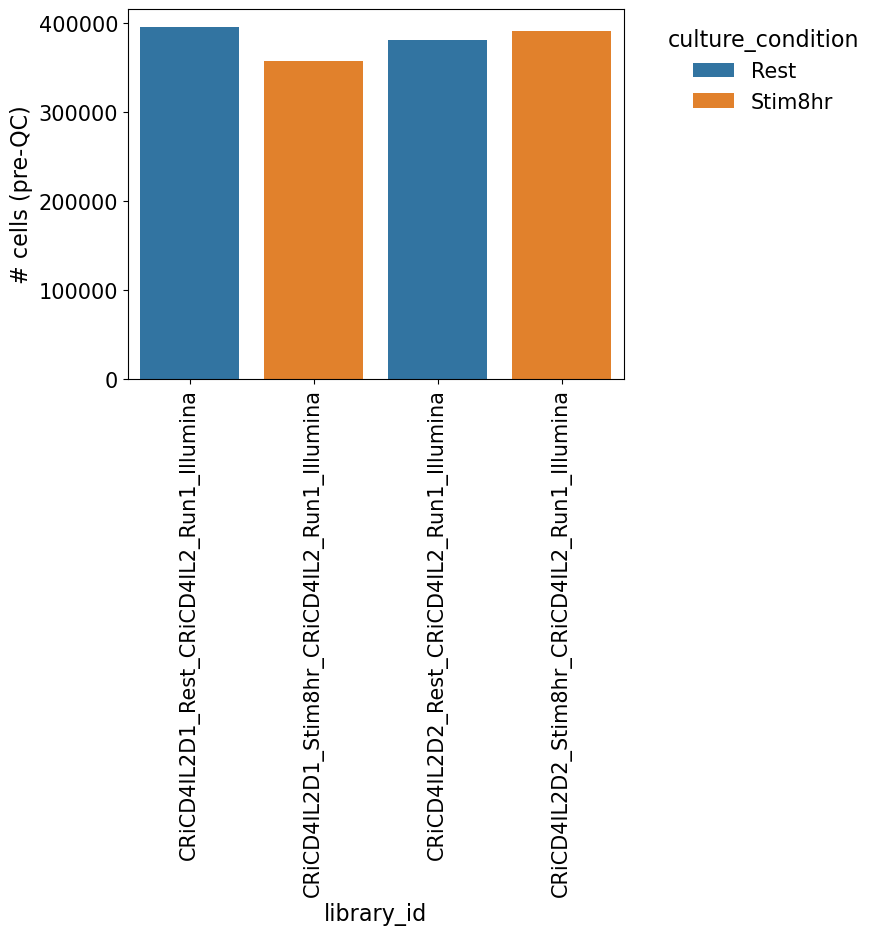

In [13]:
qc_plots.plot_ncells_sample(adata, sample_col='library_id');
save_plot(f'{experiment_name}_n_cells_preQC')

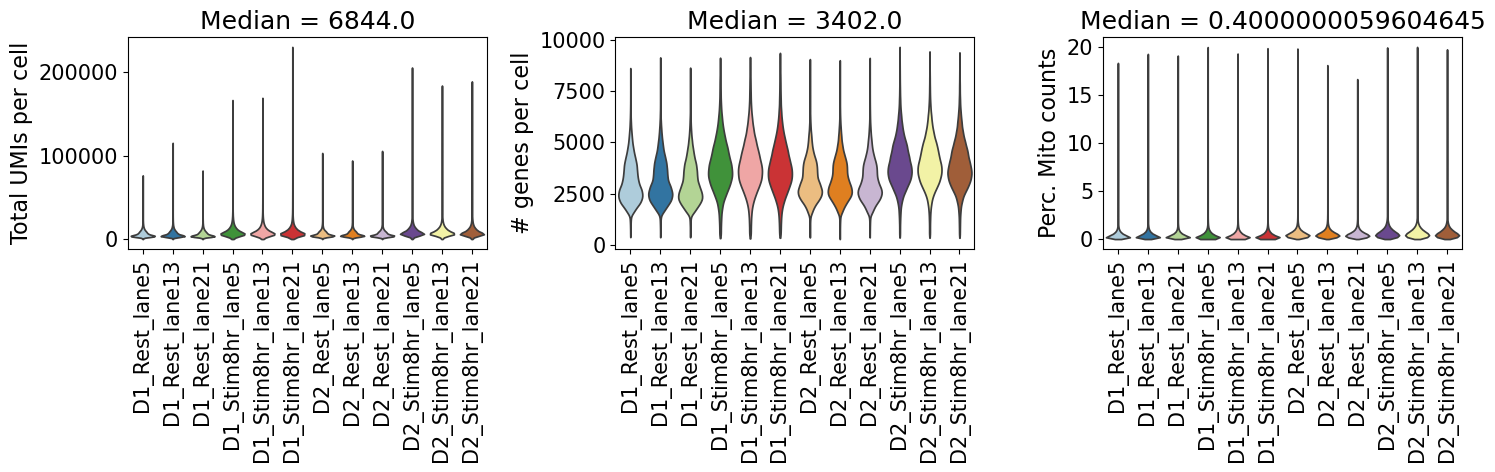

In [9]:
adata.obs['cell_sample_id_pl'] = adata.obs['cell_sample_id'].str.replace("CRiCD4IL2", '') + '_' + adata.obs['lane_id'].astype(str)
labels = {'total_counts':'Total UMIs per cell', 'n_genes':'# genes per cell', 'pct_counts_mt':'Perc. Mito counts'}
fig, axs = plt.subplots(1,3, figsize=(15,5))
for i,m in enumerate(['total_counts', 'n_genes', 'pct_counts_mt']):
    sc.pl.violin(adata, m, groupby='cell_sample_id_pl', rotation=90, show=False, ax=axs[i], stripplot=False, palette='Paired');
    axs[i].set_ylabel(labels[m])
    mean_m = np.round(adata.obs[m].median(), 2)
    axs[i].set_title(f'Median = {mean_m}');

fig.tight_layout()
fig.show()


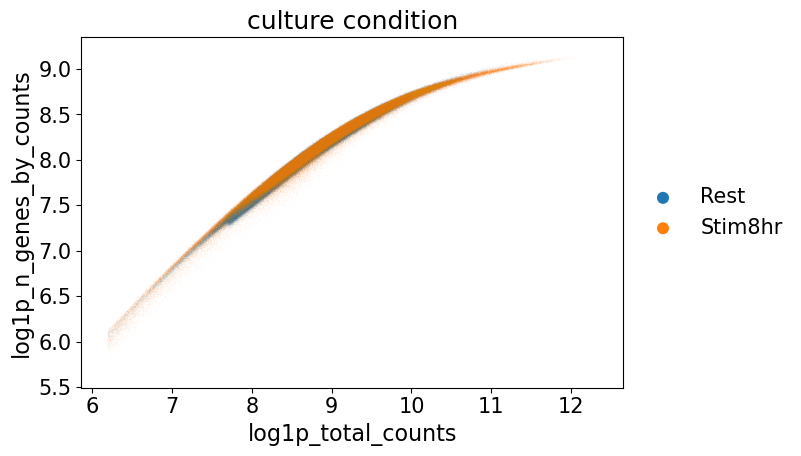

In [10]:
sc.pl.scatter(adata, 'log1p_total_counts', 'log1p_n_genes_by_counts', color='culture_condition')

In [11]:
adata.obs[['total_counts', 'n_genes', 'pct_counts_mt', "cell_sample_id"]].groupby("cell_sample_id").mean()

total_counts      n_genes  pct_counts_mt
cell_sample_id                                               
CRiCD4IL2D1_Rest      6801.593750  3107.948851       0.410066
CRiCD4IL2D1_Stim8hr  10425.476562  3865.985630       0.394306
CRiCD4IL2D2_Rest      6857.459473  3191.240215       0.566207
CRiCD4IL2D2_Stim8hr  10128.192383  3955.963164       0.668422

Estimate fraction of low quality cells (high fraction of mitochondrial genes, low number of captured genes)

In [14]:
adata.obs['low_quality'] = (adata.obs['pct_counts_mt'] > 5) | (adata.obs['n_genes'] < 500)

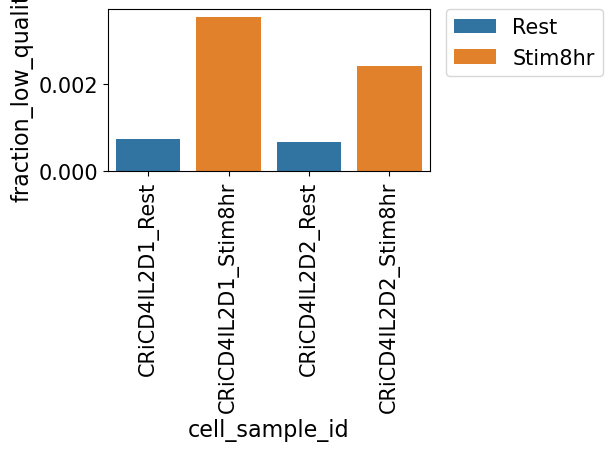

In [15]:
# plot fraction of low_quality cells for each sample_id
low_quality_df = adata.obs.groupby(["cell_sample_id", 'culture_condition'])['low_quality'].mean().reset_index(name='fraction_low_quality')
low_quality_df
sns.barplot(data=low_quality_df, x="cell_sample_id", y='fraction_low_quality', hue='culture_condition', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);


## sgRNA assignment QC metrics

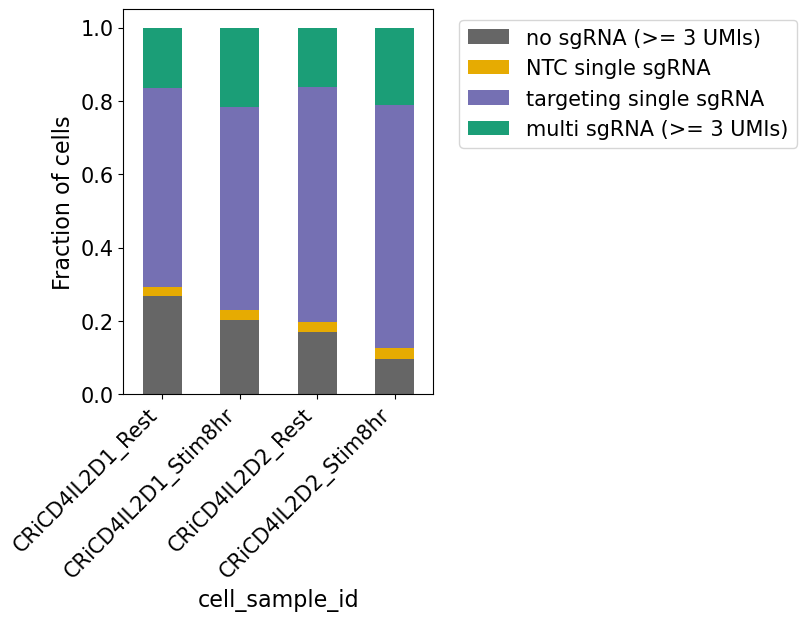

In [16]:
pl_df = adata.obs[['guide_id', "cell_sample_id", 'low_quality']]
# Initialize with default value
pl_df['group'] = ''
# Set groups in the desired order
pl_df.loc[adata.obs['guide_id'].isna(), 'group'] = 'no sgRNA (>= 3 UMIs)'
pl_df.loc[adata.obs['guide_id'].str.startswith('NTC', na=False), 'group'] = 'NTC single sgRNA'
pl_df.loc[(~adata.obs['guide_id'].isna()) & 
          (~adata.obs['guide_id'].str.startswith('NTC', na=False)) & 
          (adata.obs['guide_id'] != 'multi_sgRNA'), 'group'] = 'targeting single sgRNA'
pl_df.loc[adata.obs['guide_id'] == 'multi_sgRNA', 'group'] = 'multi sgRNA (>= 3 UMIs)'
pl_df = pl_df[~pl_df['low_quality']].copy()
# Plot stacked barplot of fraction of cells in each group for each sample

# Define the order for the groups
group_order = ['no sgRNA (>= 3 UMIs)', 'NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA (>= 3 UMIs)']
group_counts = pl_df.groupby(["cell_sample_id", 'group']).size().unstack()[group_order]
group_fractions = group_counts.div(group_counts.sum(axis=1), axis=0)
group_fractions.plot(kind='bar', stacked=True, figsize=(4,5), colormap='Dark2_r')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fraction of cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [15]:
group_counts

group                no sgRNA (>= 3 UMIs)  NTC single sgRNA  \
cell_sample_id                                                
CRiCD4IL2D1_Rest                   105781              9580   
CRiCD4IL2D1_Stim8hr                 72429              9056   
CRiCD4IL2D2_Rest                    64182             10593   
CRiCD4IL2D2_Stim8hr                 37976             11301   

group                targeting single sgRNA  multi sgRNA (>= 3 UMIs)  
cell_sample_id                                                        
CRiCD4IL2D1_Rest                     214729                    65108  
CRiCD4IL2D1_Stim8hr                  197187                    77465  
CRiCD4IL2D2_Rest                     244033                    61447  
CRiCD4IL2D2_Stim8hr                  258177                    82148

([0, 1, 2, 3],
 [Text(0, 0, 'no sgRNA (>= 3 UMIs)'),
  Text(1, 0, 'targeting single sgRNA'),
  Text(2, 0, 'multi sgRNA (>= 3 UMIs)'),
  Text(3, 0, 'NTC single sgRNA')])

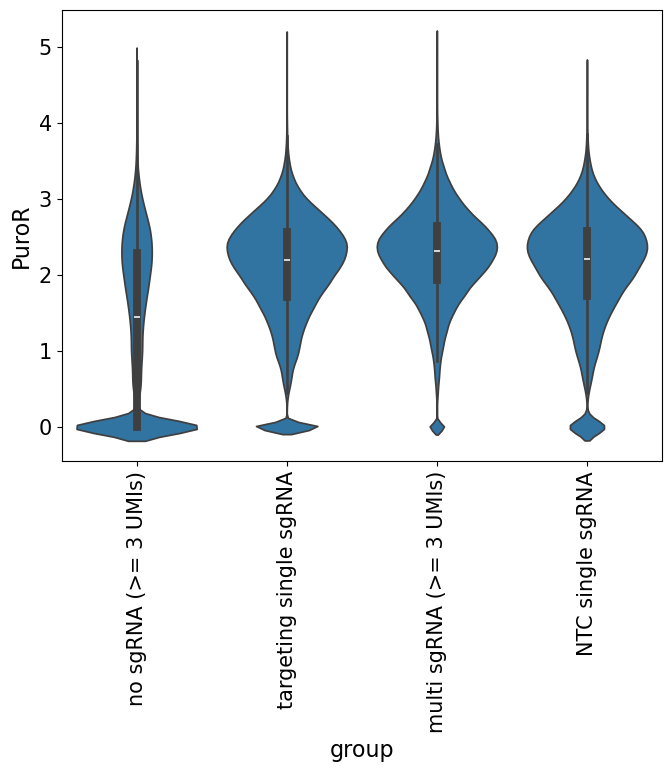

In [16]:
pl_df = sc.get.obs_df(adata, ['culture_condition', 'PuroR', 'guide_id', 'top_guide_UMI_counts'])
pl_df['group'] = 'targeting single sgRNA'
pl_df['group'] = np.where(adata.obs['guide_id'].str.startswith('NTC'), 'NTC single sgRNA', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id'].isna(), 'no sgRNA (>= 3 UMIs)', pl_df['group'])
pl_df['group'] = np.where(adata.obs['guide_id']  == 'multi_sgRNA', 'multi sgRNA (>= 3 UMIs)', pl_df['group'])

plt.figure(figsize=(7,8))
sns.violinplot(data=pl_df, x='group', y='PuroR', scale='width');
plt.xticks(rotation=90)

In [16]:
# no_guide_cells = adata.obs_names[adata.obs['guide_id'].isna()]
# multi_guide_cells = adata.obs_names[adata.obs['guide_id'] == 'multi_sgRNA']

# fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# for i, (sample_id, crispr_a) in enumerate(all_crispr_a.items()):
#     crispr_a.obs['multi_sgrna'] = crispr_a.obs_names.isin(multi_guide_cells)
#     crispr_a.obs['no_sgrna'] = crispr_a.obs_names.isin(no_guide_cells)
#     crispr_a.obs['targeting_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'targeting'].X.sum(axis=1)).flatten()
#     crispr_a.obs['ntc_umis'] = np.array(crispr_a[:, crispr_a.var['sgrna_type'] == 'NTC'].X.sum(axis=1)).flatten()
#     crispr_a.obs['inefficient_umis'] = np.array(crispr_a[:, crispr_a.var['inefficient']].X.sum(axis=1)).flatten()
#     crispr_a.obs['nonspecific_umis'] = np.array(crispr_a[:, crispr_a.var['nonspecific']].X.sum(axis=1)).flatten()

#     ntc_n = sum(no_sgrna_a.obs['ntc_umis'] > 3)
#     tot_n = no_sgrna_a.n_obs
#     subtitle = f'{ntc_n}/{tot_n} multi sgRNA cells with NTC sgRNAs'
#     no_sgrna_a = crispr_a[crispr_a.obs['multi_sgrna']].copy()
    
#     axes[i].scatter(no_sgrna_a.obs['ntc_umis'], no_sgrna_a.obs['targeting_umis'], s=3)
#     axes[i].set_xscale('log')
#     axes[i].set_yscale('log')
#     axes[i].set_xlabel('NTC sgRNA UMI counts')
#     axes[i].set_ylabel('Targeting sgRNA UMI counts')
#     axes[i].set_title('Multi sgRNA cells - ' + crispr_a.obs["cell_sample_id"][0] + '\n' + subtitle)

# plt.tight_layout()
# plt.show()

In [14]:
obs_df.columns

Index(['library_id', 'lane_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch',
       'cell_sample_id', 'donor_id', 'culture_condition',
       'top_guide_UMI_counts', 'guide_id', 'perturbed_gene_name',
       'perturbed_gene_id', 'guide_type', 'low_quality', 'louvain', 'QC_mask'],
      dtype='object')

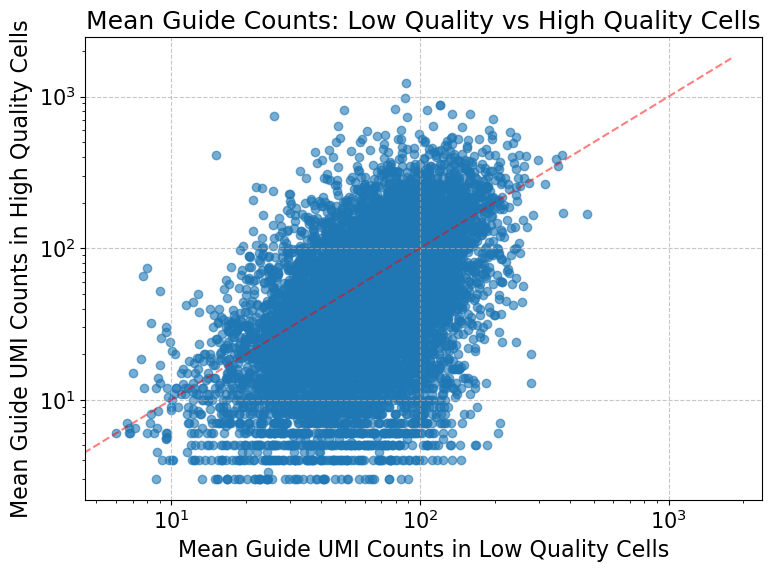

In [26]:
# Group by QC_mask and calculate mean number of guides
guide_counts = obs_df.groupby('QC_mask')['top_guide_UMI_counts'].mean()
# Group guides by guide_id and QC_mask to compare mean counts in low vs high quality cells
guide_mean_by_quality = obs_df.groupby(['guide_id', 'QC_mask'])['top_guide_UMI_counts'].mean().unstack()

# Create a scatter plot comparing low quality vs high quality guide counts
plt.figure(figsize=(8, 6))
plt.scatter(guide_mean_by_quality[True], guide_mean_by_quality[False], alpha=0.6)

# Add a diagonal line for reference
max_val = max(guide_mean_by_quality.max().max(), 1)
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)

plt.title('Mean Guide Counts: Low Quality vs High Quality Cells')
plt.xlabel('Mean Guide UMI Counts in Low Quality Cells')
plt.ylabel('Mean Guide UMI Counts in High Quality Cells')
plt.grid(True, linestyle='--', alpha=0.7)

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

Compare background guide expression with signal guide expression

In [30]:
from sgrna_assignment import get_background_vs_signal_guide_counts
all_guides_combined, summary_df = get_background_vs_signal_guide_counts(datadir, return_summary=True)

In [31]:
summary_df = summary_df.sort_values('signal', ascending=False).reset_index()
summary_df.index.name = None
summary_df.columns = ['gRNA', 'mean_n_UMI_background', 'mean_n_UMI_signal']
summary_df.head()

gRNA  mean_n_UMI_background  mean_n_UMI_signal
0  GPKOW-1                    1.0             1786.0
1  EIF3M-2                    1.0             1595.5
2  RPL39-1                    1.0              883.0
3  BRIP1-2                    1.0              852.5
4  RNF20-1                    1.0              823.0

In [32]:
all_guides_combined.head()

cell       gRNA  \
0  AAACAAGCAAACCGGTACTACTCA-1_lane13_CRiCD4IL2D1_...   NIPAL3-1   
1  AAACAAGCAAACGGTCAGTGAGTG-1_lane13_CRiCD4IL2D1_...  FAM208A-1   
2  AAACAAGCAAACGGTCAGTGAGTG-1_lane13_CRiCD4IL2D1_...  IL12RB2-2   
3  AAACAAGCAAACGGTCAGTGAGTG-1_lane13_CRiCD4IL2D1_...    RBM33-2   
4  AAACAAGCAAATAACCACAGTCTG-1_lane13_CRiCD4IL2D1_...   DYNLT3-1   

   UMI_counts_all  UMI_counts_assigned signal_vs_bg  \
0            96.0                 96.0       signal   
1             1.0                  NaN   background   
2           176.0                176.0       signal   
3             1.0                  NaN   background   
4             1.0                  NaN   background   

                                              sample  
0  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina.la...  
1  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina.la...  
2  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina.la...  
3  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina.la...  
4  CRiCD4IL2D1_Stim8hr_CRiCD4IL2_Run1_Illumina.la...

In [40]:
summary_df.to_csv(f'../../results/{experiment_name}/median_grna_umis_signal_vs_background.csv')
all_guides_combined.to_csv(f'{datadir}/{experiment_name}.merged_sgrna_assignment.csv.gz', compression='gzip')

Text(0, 0.5, 'Median UMI Counts as Signal')

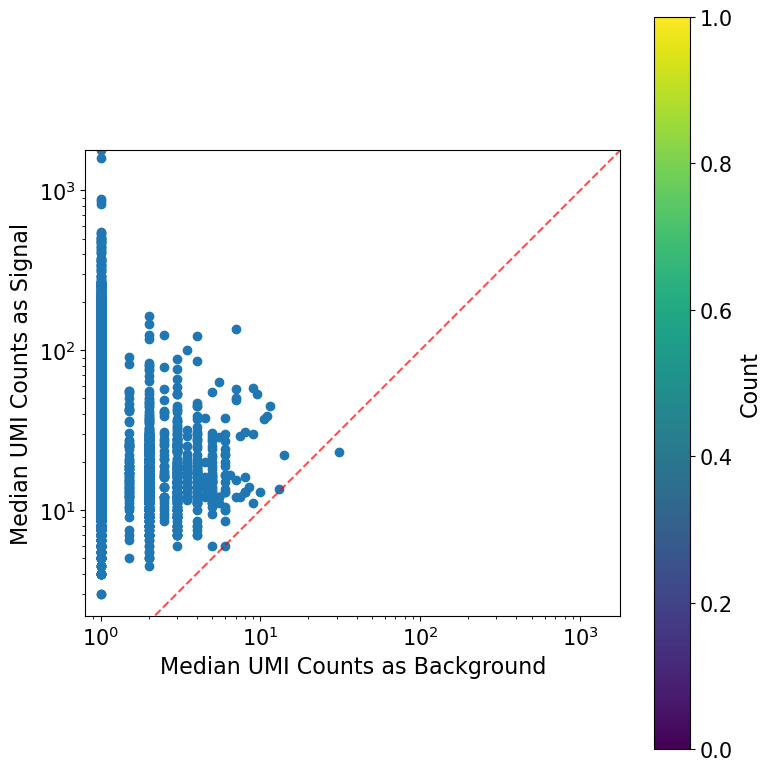

In [52]:
import matplotlib
# Get the data range to set equal axis limits
max_val = max(summary_df['mean_n_UMI_background'].max(), summary_df['mean_n_UMI_signal'].max())
min_val = min(summary_df['mean_n_UMI_background'].min(), summary_df['mean_n_UMI_signal'].min())

plt.figure(figsize=(8, 8))  # Square figure for equal aspect ratio
plt.scatter(summary_df['mean_n_UMI_background'], summary_df['mean_n_UMI_signal'])
plt.colorbar(label='Count')
plt.xscale('log');plt.yscale('log');

# Set equal limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.gca().set_aspect('equal')  # Make axes proportional

# Add a diagonal line for reference
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)

plt.xlabel('Median UMI Counts as Background')
plt.ylabel('Median UMI Counts as Signal')
# plt.title('2D Histogram of Background vs Signal UMI Counts')

## Dimensionality reduction

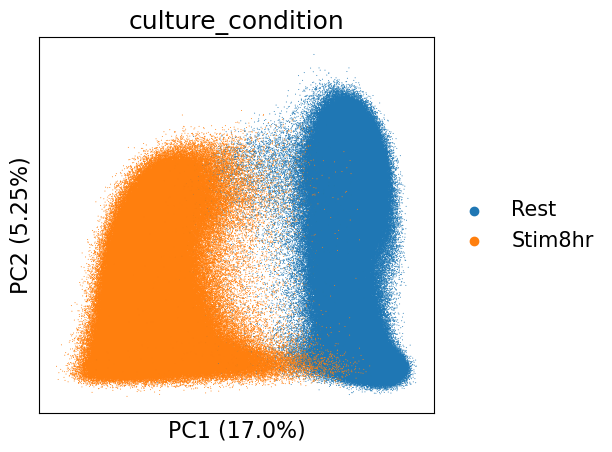

In [18]:
sc.pl.pca(adata, annotate_var_explained=True, color=['culture_condition'], components=['1,2'], wspace=0.5, ncols=3, size=2)

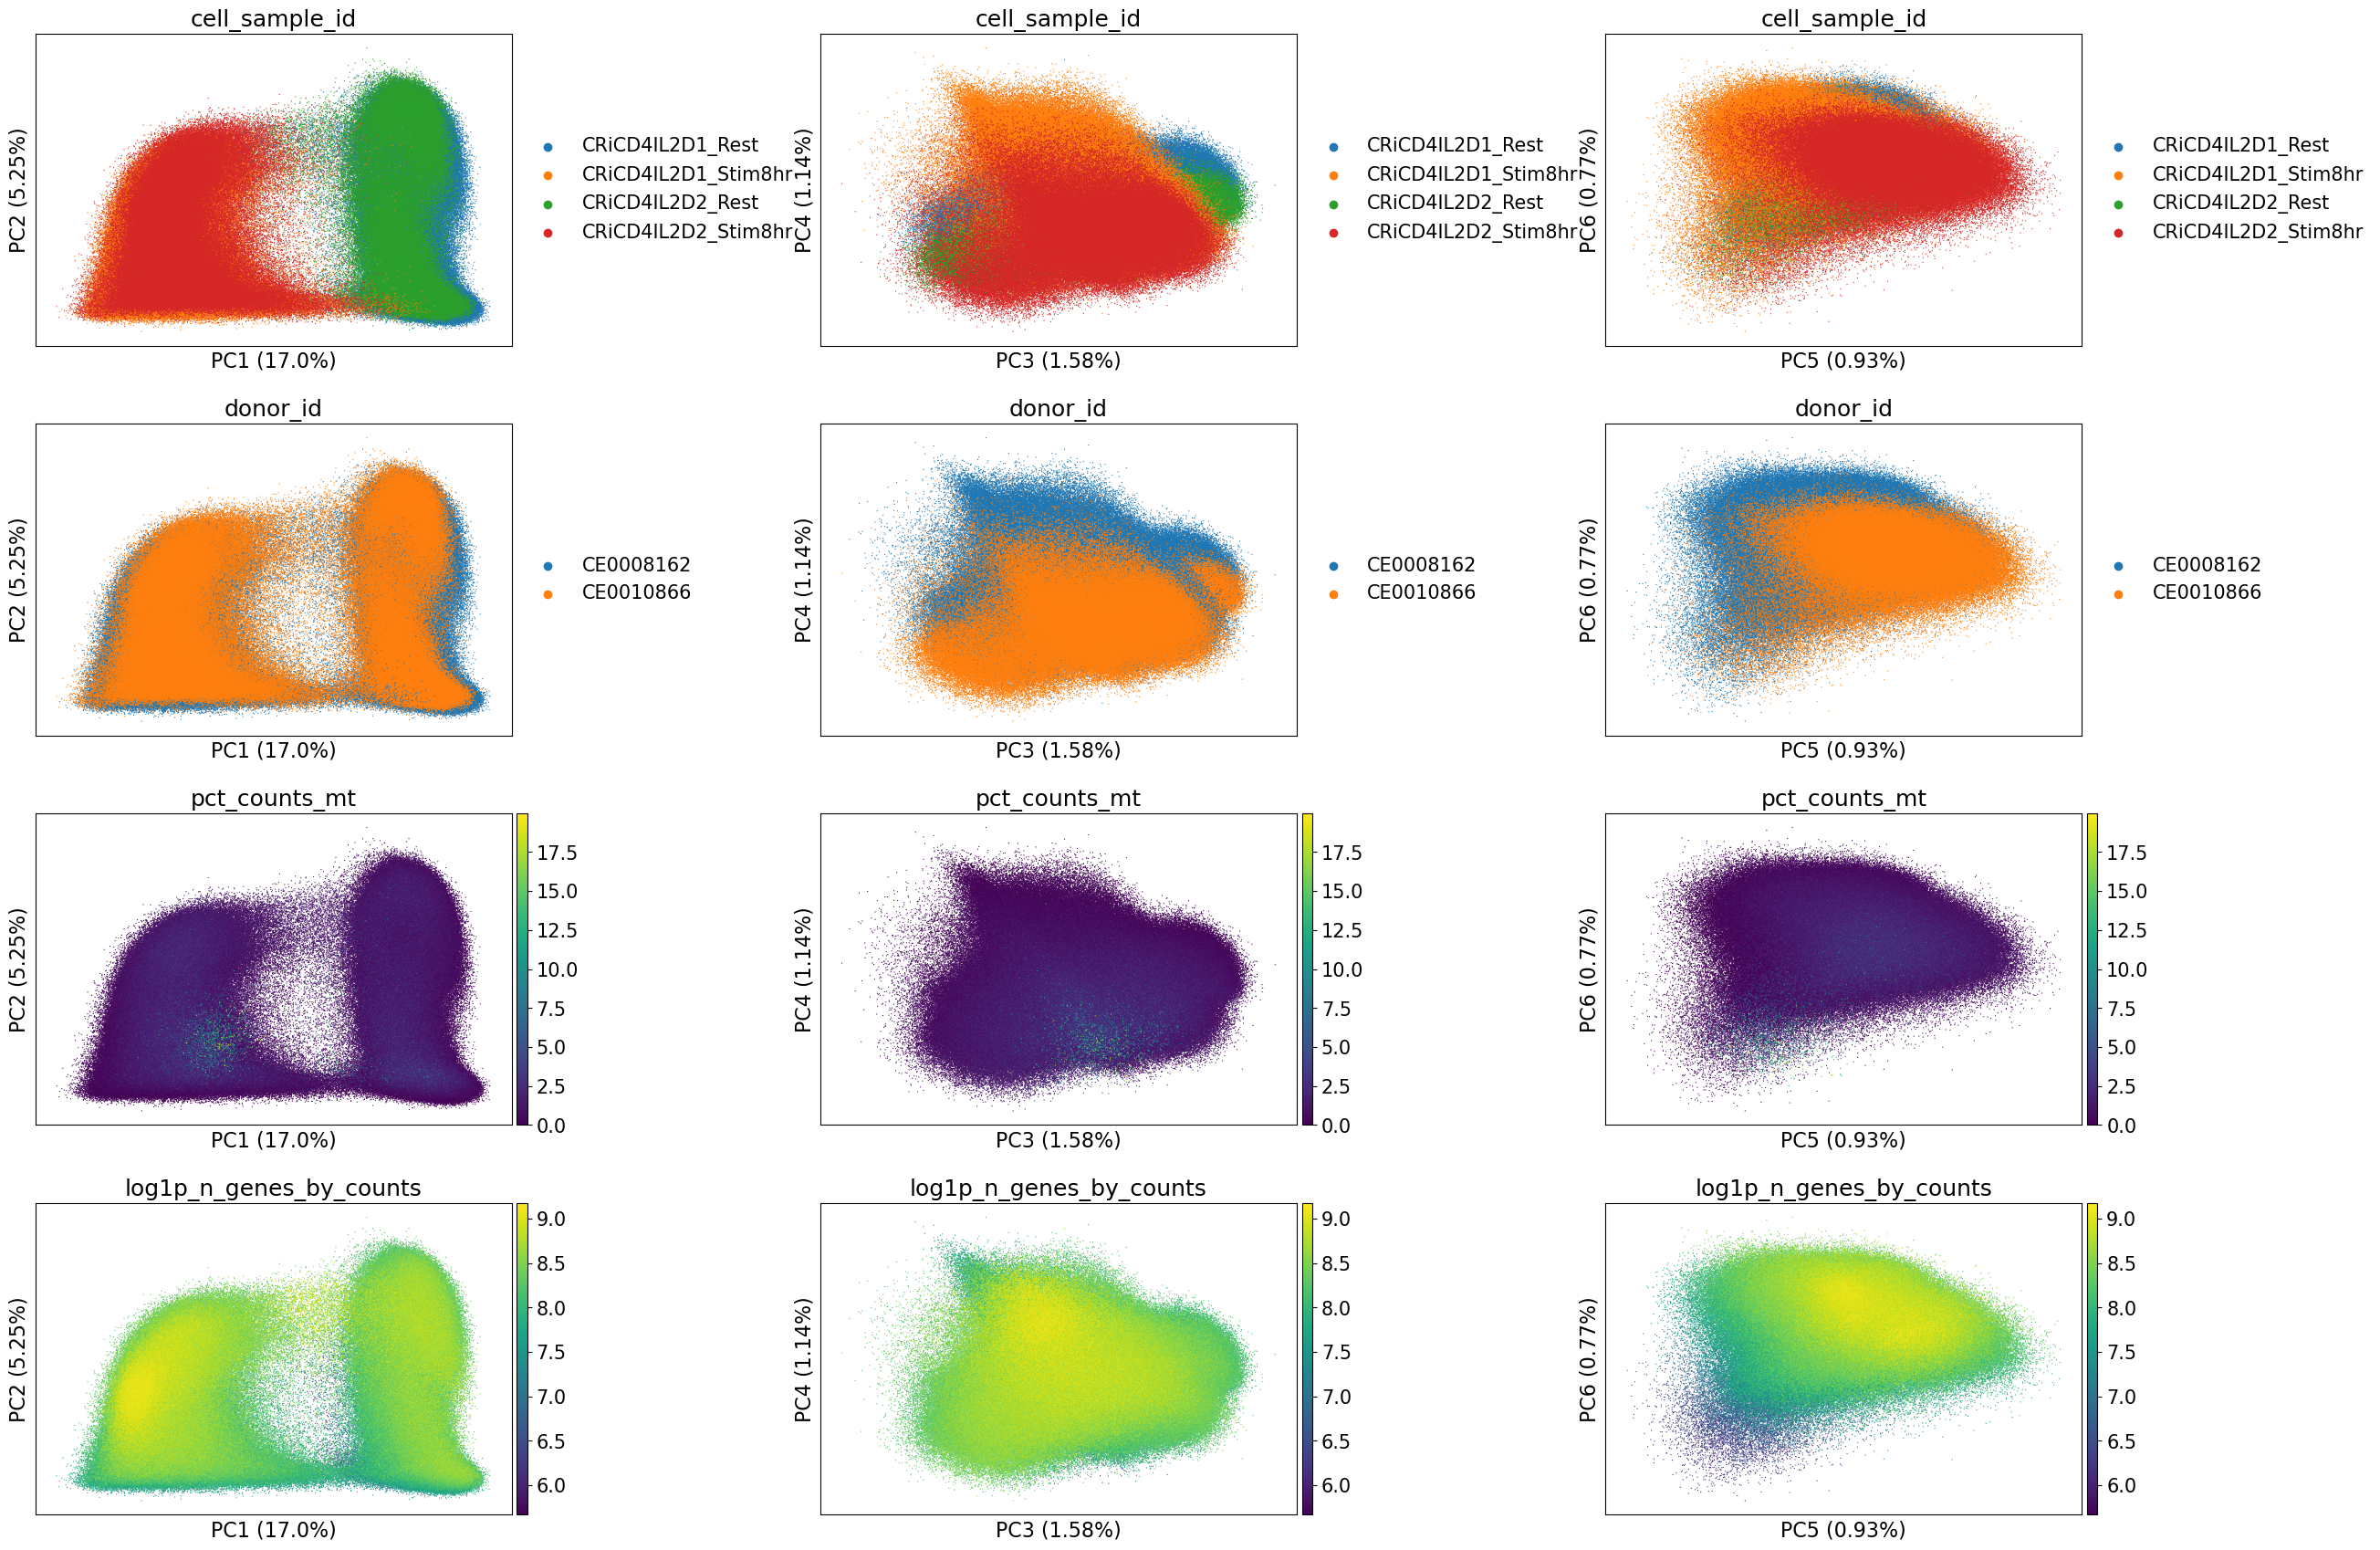

In [19]:
sc.pl.pca(adata, annotate_var_explained=True, color=["cell_sample_id", "donor_id", 'pct_counts_mt', 'log1p_n_genes_by_counts'], components=['1,2', '3,4', '5,6'], wspace=0.5, ncols=3, size=3)

Visualize genes with top loadings for each PC

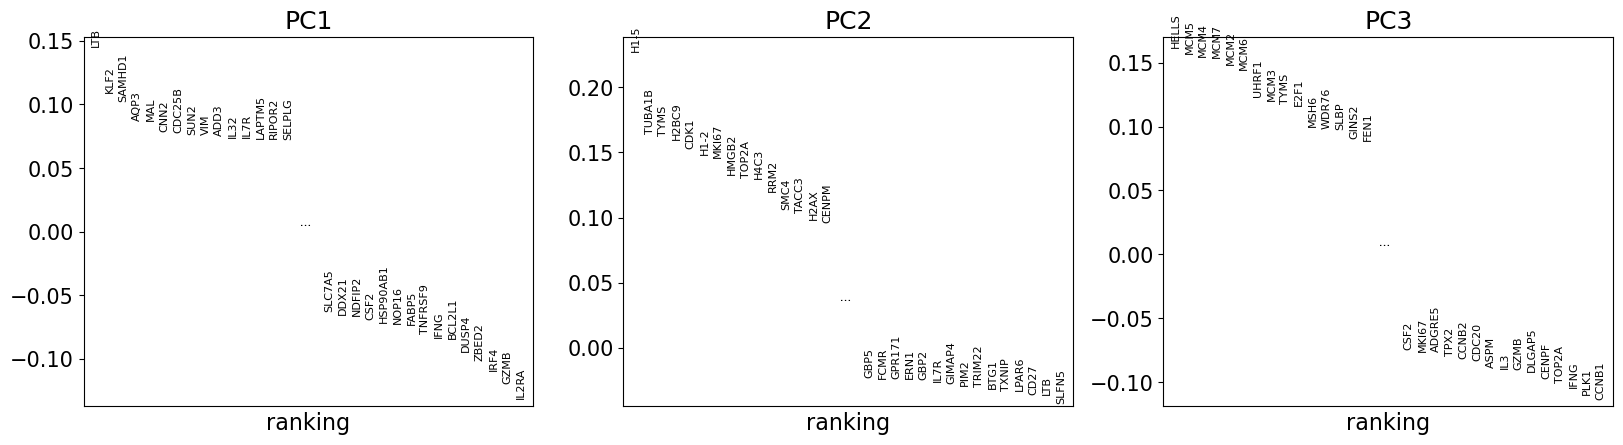

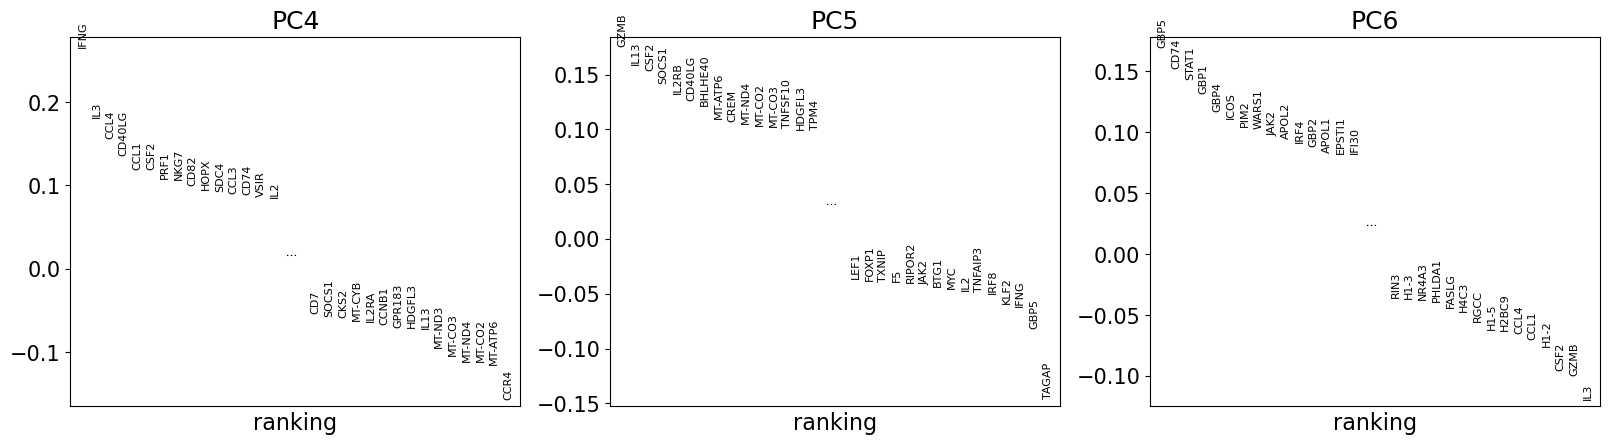

In [20]:
sc.pl.pca_loadings(adata, components='1,2,3');
sc.pl.pca_loadings(adata, components='4,5,6')

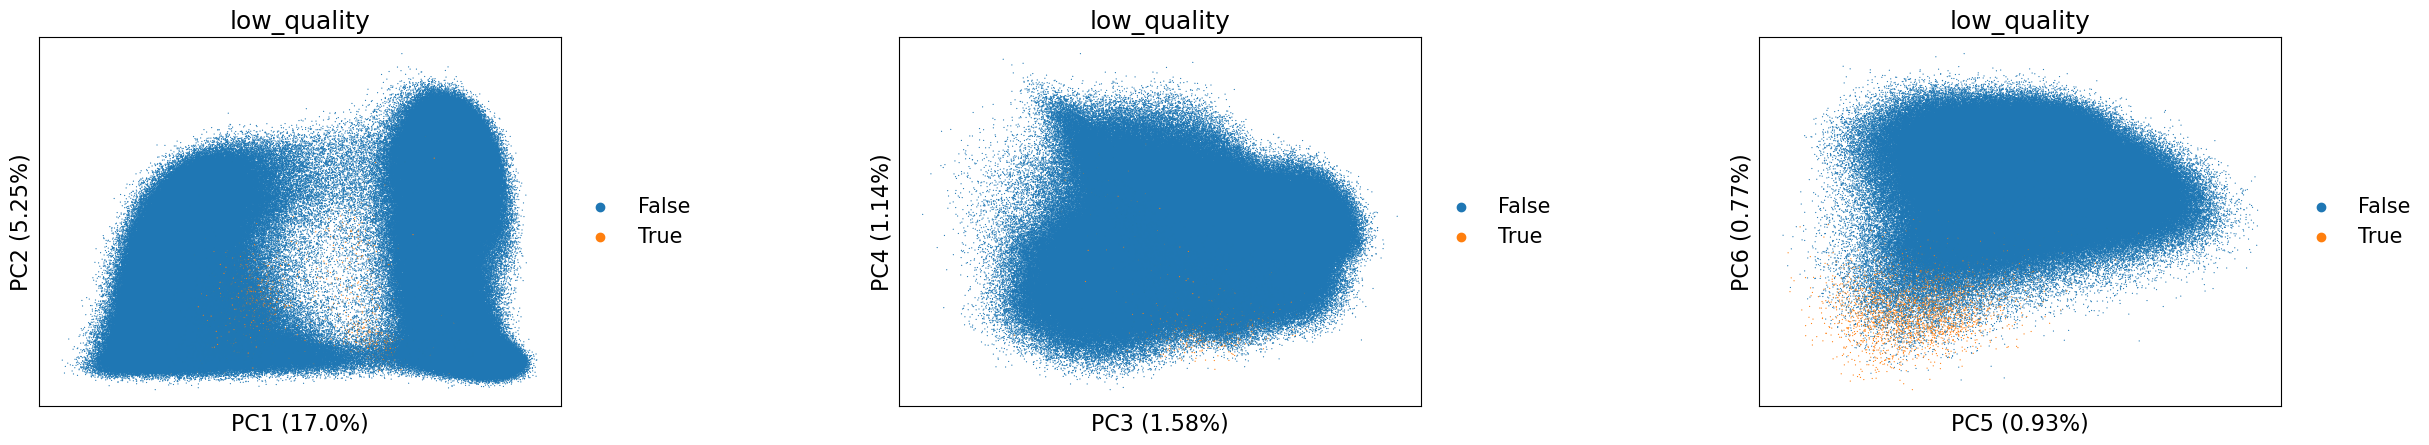

In [21]:
sc.pl.pca(adata, annotate_var_explained=True, color=["low_quality"], components=['1,2', '3,4', '5,6'], wspace=0.5, ncols=3, size=3)

## Clustering

In [17]:
rsc.pp.neighbors(adata, n_neighbors=50)
rsc.tl.umap(adata)
rsc.tl.louvain(adata)

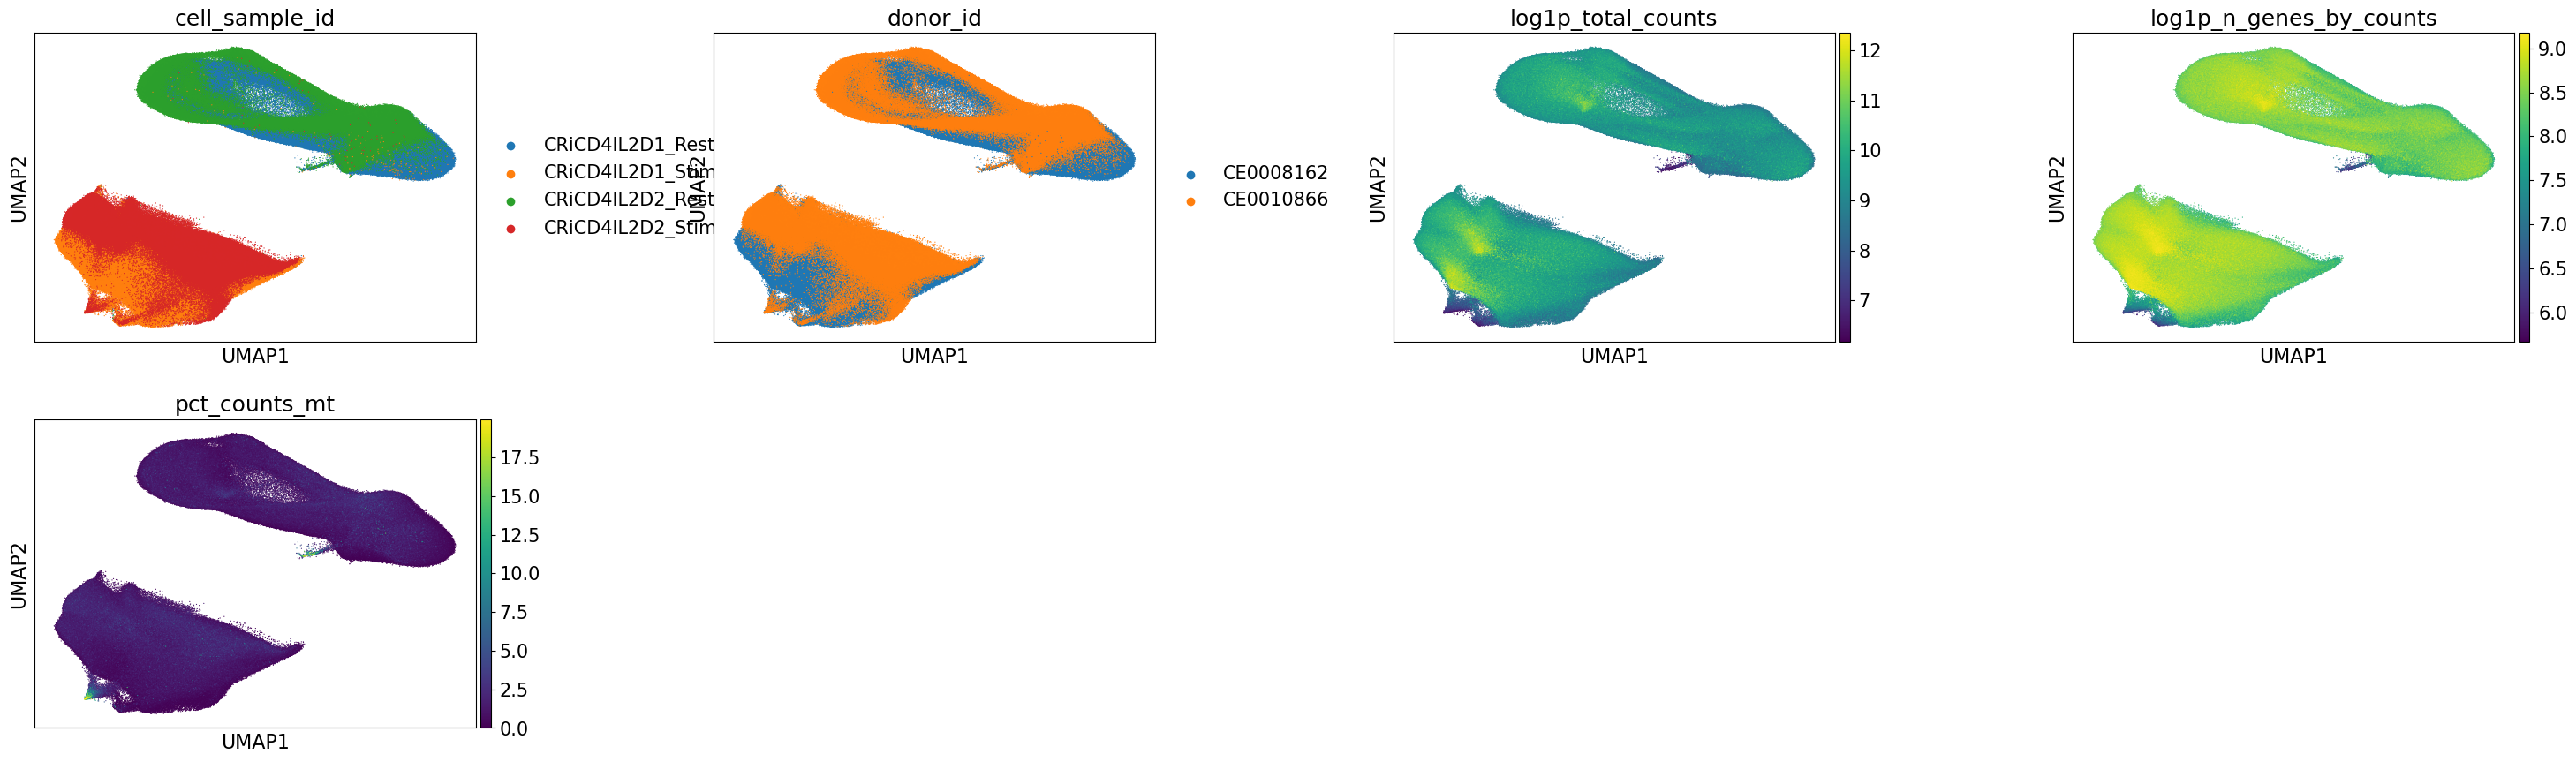

In [23]:
sc.pl.umap(adata, color=["cell_sample_id", 'donor_id'] + ['log1p_total_counts','log1p_n_genes_by_counts','pct_counts_mt'], wspace=0.4, size=3)

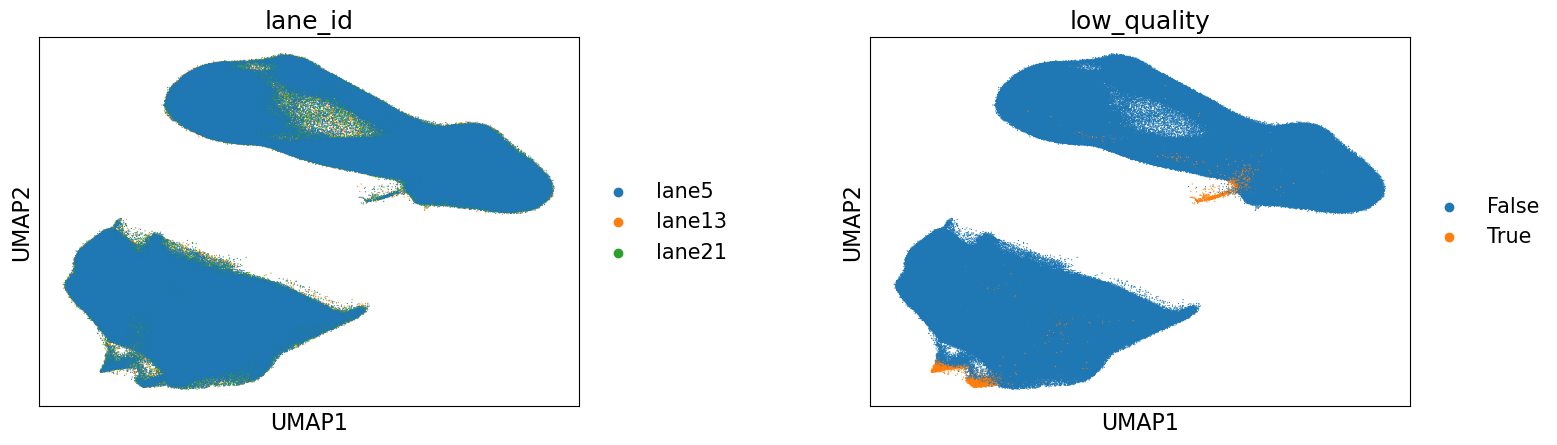

In [26]:
sc.pl.umap(adata, color=["lane_id"] + ['low_quality'], wspace=0.4, size=3)

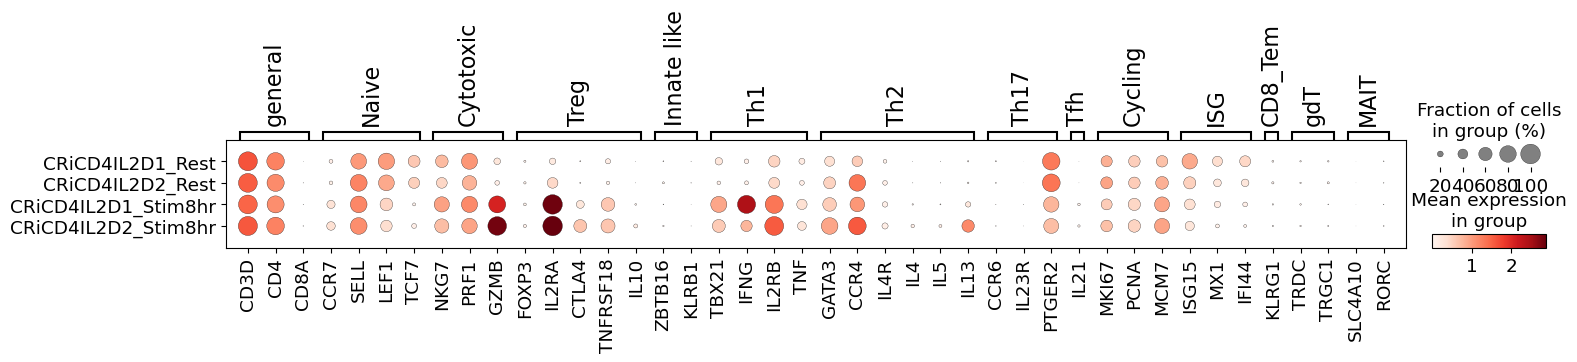

In [27]:
qc_plots.plot_markers_sample_dotplot(adata, save=f'{experiment_name}_markers_sample_dotplot')

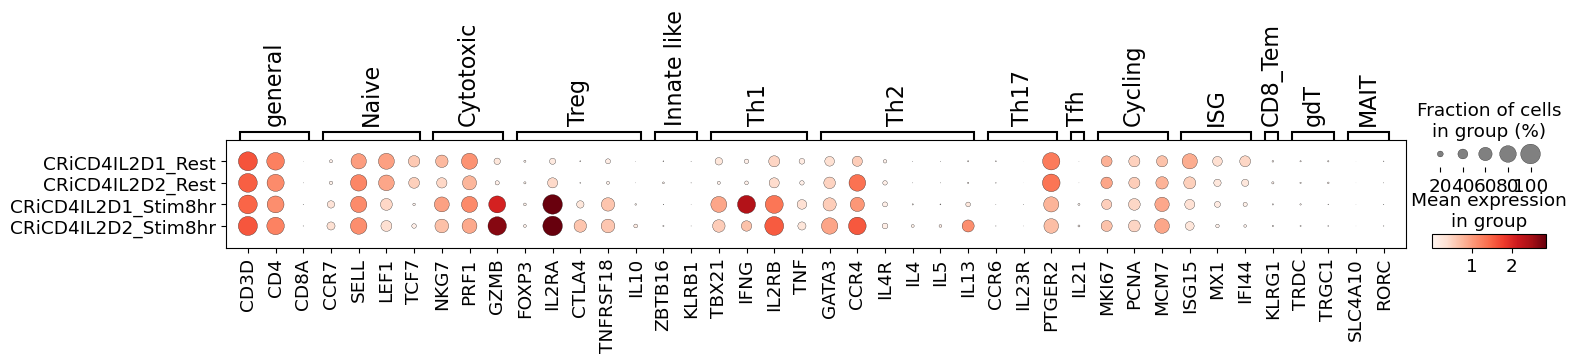

In [28]:
qc_plots.plot_markers_sample_dotplot(adata[adata.obs['guide_type'] == 'non-targeting'], save=f'{experiment_name}_markers_sample_dotplot_ntcs')

In [31]:
# qc_plots.plot_markers_umap(adata, wspace=0.1, size=3, cmap='magma', ncols=5, save=f'{experiment_name}_markers.png')

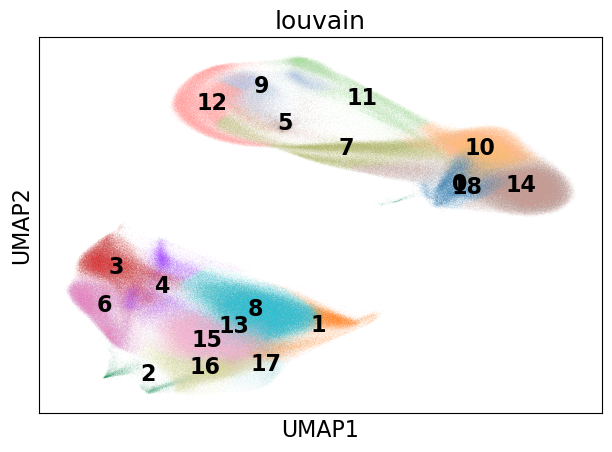

In [29]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

<Axes: xlabel='louvain', ylabel='pct_counts_mt'>

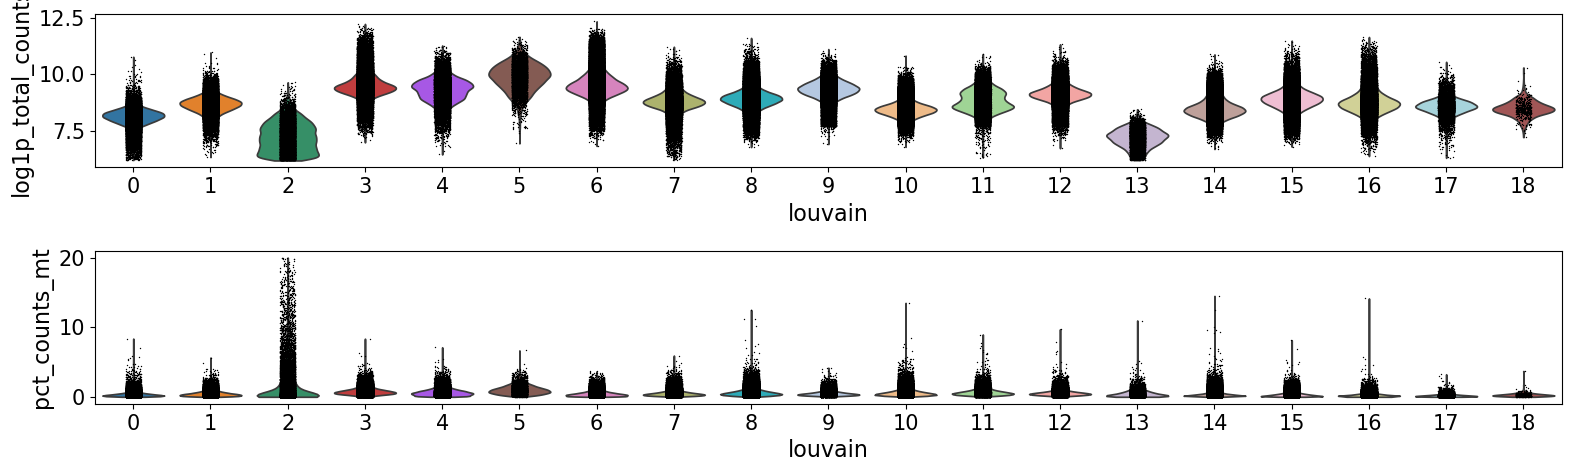

In [24]:
fig,axs = plt.subplots(2,1,figsize=(16, 5))
sc.pl.violin(adata, ['log1p_total_counts'], groupby='louvain', ax=axs[0], show=False)
sc.pl.violin(adata, ['pct_counts_mt'], groupby='louvain', ax=axs[1], show=False)

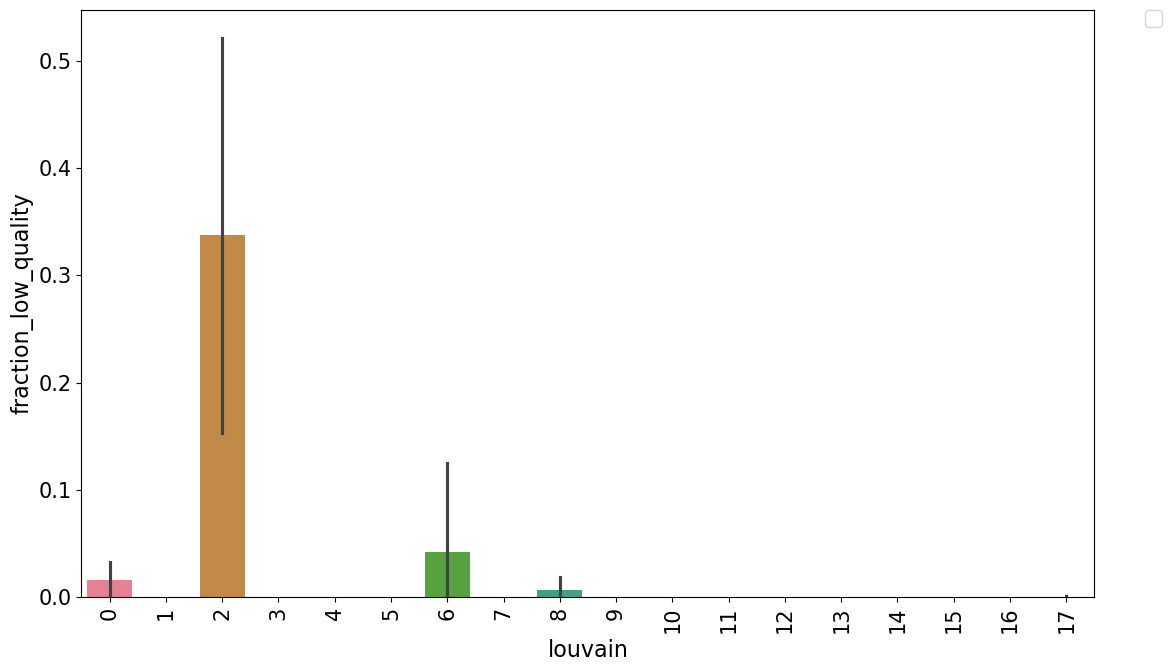

In [18]:
# plot fraction of low_quality cells for each cluster
low_quality_df = adata.obs.groupby(["cell_sample_id", 'louvain'])['low_quality'].mean().reset_index(name='fraction_low_quality')

plt.figure(figsize=(12,7))
sns.barplot(data=low_quality_df, x='louvain', y='fraction_low_quality', hue='louvain', dodge=False);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

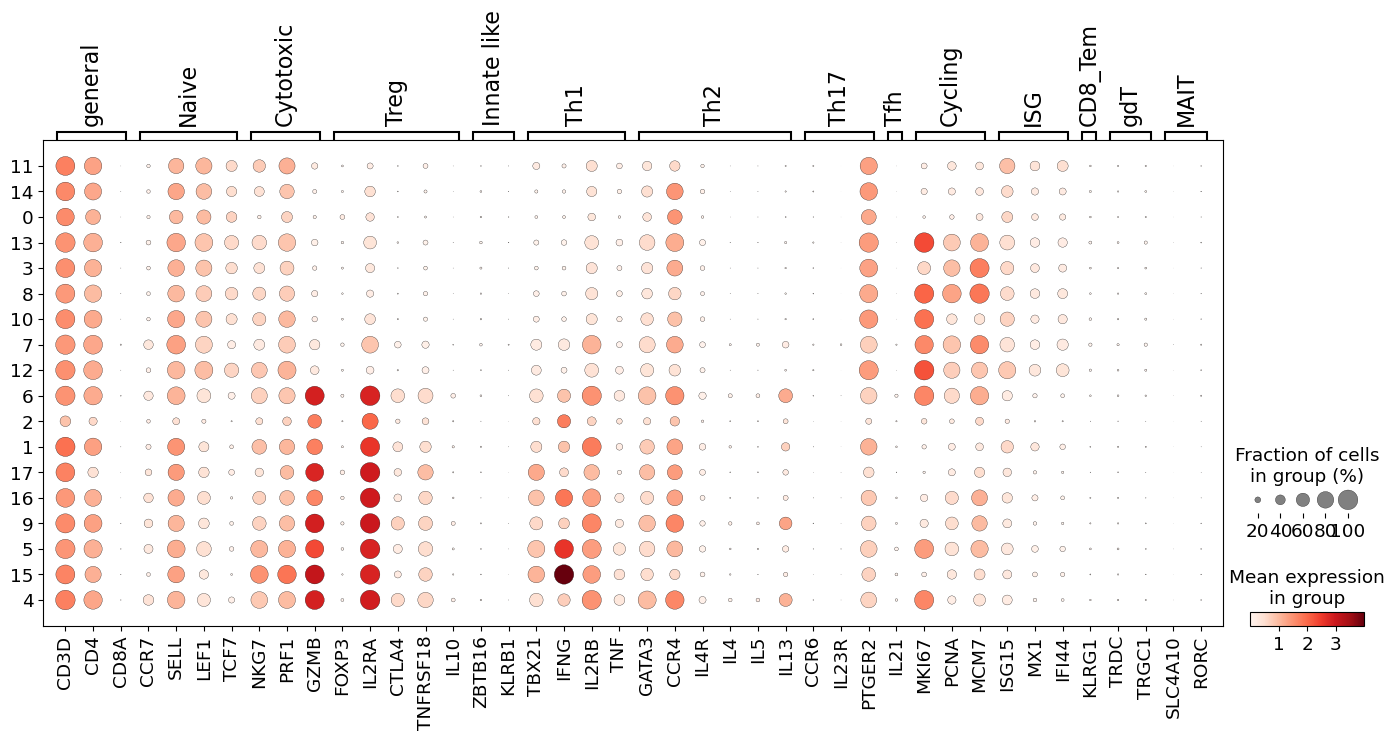

In [19]:
group_by = 'culture_condition'
markers_dict = qc_plots.load_Tcell_markers(adata)
order_samples = adata.obs.sort_values([group_by])['louvain'].astype(str).unique()
adata.obs['louvain'] = adata.obs['louvain'].cat.reorder_categories(order_samples)
sc.pl.dotplot(adata, markers_dict, groupby='louvain')

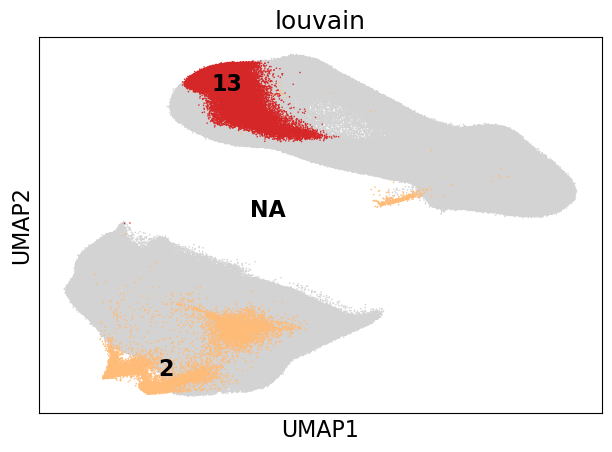

In [20]:
low_quality_clusters = ['2', '13']
sc.pl.umap(adata, color='louvain', legend_loc='on data', size=5, groups=low_quality_clusters)

Checking that no perturbation is over-represented in low quality cells

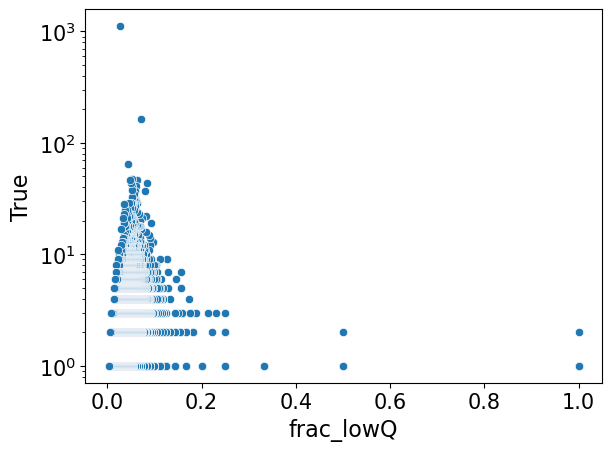

In [21]:
perts_df = adata.obs[['louvain', 'low_quality','top_guide_UMI_counts', 'guide_id', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type']]
perts_df['low_quality'] = (perts_df['louvain'].isin(low_quality_clusters)) | (perts_df['low_quality'])
perts_df = perts_df.value_counts(['perturbed_gene_name', 'low_quality']).reset_index().pivot(columns='low_quality', index='perturbed_gene_name', values='count').fillna(0)
perts_df = perts_df[perts_df[True] > 0]
perts_df['frac_lowQ'] = perts_df[True] / (perts_df[True]+perts_df[False])
perts_df = perts_df.sort_values('frac_lowQ', ascending=False)

sns.scatterplot(data=perts_df, x='frac_lowQ', y=True);
plt.yscale('log')

Text(0, 0.5, 'Cumulative Probability')

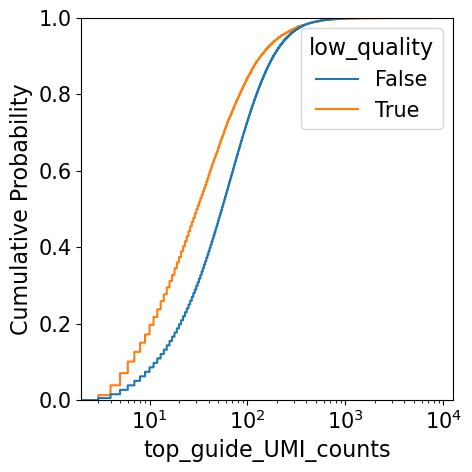

In [29]:
perts_df = adata.obs[['louvain', 'low_quality','top_guide_UMI_counts', 'guide_id', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type']]
perts_df['low_quality'] = (perts_df['louvain'].isin(low_quality_clusters)) | (perts_df['low_quality'])

# Create ECDF plots to compare top guide UMI counts between low quality and high quality cells
plt.figure(figsize=(5, 5))
# Plot empirical cumulative distribution function for each group
sns.ecdfplot(data=perts_df, x='top_guide_UMI_counts', hue='low_quality')
plt.xscale('log')
plt.xlabel('top_guide_UMI_counts')
plt.ylabel('Cumulative Probability')
# plt.title('ECDF of top guide UMI counts by cell quality')
# plt.legend(title='low_quality')

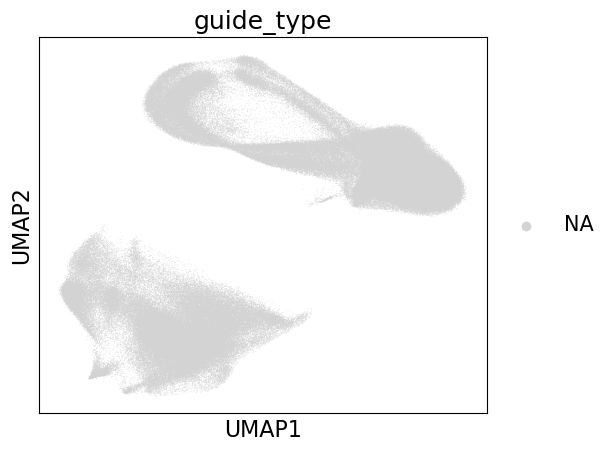

In [52]:
sc.pl.umap(adata[adata.obs['guide_type'].isna()], color='guide_type', size=1)

In [22]:
adata.obs[adata.obs['low_quality']]['guide_type'].astype(str).value_counts()

guide_type
nan              1462
targeting        1252
non-targeting      49
Name: count, dtype: int64

In [23]:
print('Total cells with no sgRNA:', sum(adata.obs['guide_id'].isna()))
print('Total multi-sgRNA cells:', sum(adata.obs['guide_id'] == 'multi_sgRNA'))
print('Total cells with high quality perturbation:', sum(~adata.obs['guide_type'].isna()))

Total cells with no sgRNA: 281830
Total multi-sgRNA cells: 286310
Total cells with high quality perturbation: 1242125


In [33]:
# Remove constant columns from adata.obs
constant_cols = {}
for col in adata.obs.columns:
    if len(adata.obs[col].unique()) == 1:
        constant_cols[col] = adata.obs[col].iloc[0]
adata.obs = adata.obs.drop(columns=list(constant_cols.keys()))
adata.uns['experiment_metadata'] = constant_cols

library_id  \
AAACAAGCAAATAACCACTTTAGG-1_lane13_CRiCD4IL2D1_R...     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina   
AAACAAGCAAATACCGAACGGGAA-1_lane13_CRiCD4IL2D1_R...     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina   
AAACAAGCAAATACCGATGTTGAC-1_lane13_CRiCD4IL2D1_R...     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina   
AAACAAGCAACCGTAAAGTAGGCT-1_lane13_CRiCD4IL2D1_R...     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina   
AAACAAGCAACTGTTCACTTTAGG-1_lane13_CRiCD4IL2D1_R...     CRiCD4IL2D1_Rest_CRiCD4IL2_Run1_Illumina   
...                                                                                         ...   
TTTGTGAGTTGGGTTTATCATGTG-1_lane5_CRiCD4IL2D2_St...  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina   
TTTGTGAGTTGTCCAGATCATGTG-1_lane5_CRiCD4IL2D2_St...  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina   
TTTGTGAGTTGTCCAGATTCGGTT-1_lane5_CRiCD4IL2D2_St...  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina   
TTTGTGAGTTTCCAAAAACGCCGA-1_lane5_CRiCD4IL2D2_St...  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina   
TTTGTGAGTTTCCAAAATTCGGTT-1_lane5_CRiCD4IL2D2_St...  CRiCD4IL2D2_Stim8hr_CRiCD4IL2_Run1_Illumina   

                                                   lane_id  n_genes_by_counts  \
AAACAAGCAAATAACCACTTTAGG-1_lane13_CRiCD4IL2D1_R...  lane13               2725   
AAACAAGCAAATACCGAACGGGAA-1_lane13_CRiCD4IL2D1_R...  lane13               2492   
AAACAAGCAAATACCGATGTTGAC-1_lane13_CRiCD4IL2D1_R...  lane13               3596   
AAACAAGCAACCGTAAAGTAGGCT-1_lane13_CRiCD4IL2D1_R...  lane13               2311   
AAACAAGCAACTGTTCACTTTAGG-1_lane13_CRiCD4IL2D1_R...  lane13               3186   
...                                                    ...                ...   
TTTGTGAGTTGGGTTTATCATGTG-1_lane5_CRiCD4IL2D2_St...   lane5               3762   
TTTGTGAGTTGTCCAGATCATGTG-1_lane5_CRiCD4IL2D2_St...   lane5               2529   
TTTGTGAGTTGTCCAGATTCGGTT-1_lane5_CRiCD4IL2D2_St...   lane5               7169   
TTTGTGAGTTTCCAAAAACGCCGA-1_lane5_CRiCD4IL2D2_St...   lane5               4648   
TTTGTGAGTTTCCAAAATTCGGTT-1_lane5_CRiCD4IL2D2_St...   lane5               3388   

                                                    log1p_n_genes_by_counts  \
AAACAAGCAAATAACCACTTTAGG-1_lane13_CRiCD4IL2D1_R...                 7.910591   
AAACAAGCAAATACCGAACGGGAA-1_lane13_CRiCD4IL2D1_R...                 7.821242   
AAACAAGCAAATACCGATGTTGAC-1_lane13_CRiCD4IL2D1_R...                 8.187855   
AAACAAGCAACCGTAAAGTAGGCT-1_lane13_CRiCD4IL2D1_R...                 7.745868   
AAACAAGCAACTGTTCACTTTAGG-1_lane13_CRiCD4IL2D1_R...                 8.066835   
...                                                                     ...   
TTTGTGAGTTGGGTTTATCATGTG-1_lane5_CRiCD4IL2D2_St...                 8.232972   
TTTGTGAGTTGTCCAGATCATGTG-1_lane5_CRiCD4IL2D2_St...                 7.835975   
TTTGTGAGTTGTCCAGATTCGGTT-1_lane5_CRiCD4IL2D2_St...                 8.877661   
TTTGTGAGTTTCCAAAAACGCCGA-1_lane5_CRiCD4IL2D2_St...                 8.444407   
TTTGTGAGTTTCCAAAATTCGGTT-1_lane5_CRiCD4IL2D2_St...                 8.128290   

                                                    total_counts  \
AAACAAGCAAATAACCACTTTAGG-1_lane13_CRiCD4IL2D1_R...        4694.0   
AAACAAGCAAATACCGAACGGGAA-1_lane13_CRiCD4IL2D1_R...        4496.0   
AAACAAGCAAATACCGATGTTGAC-1_lane13_CRiCD4IL2D1_R...        7388.0   
AAACAAGCAACCGTAAAGTAGGCT-1_lane13_CRiCD4IL2D1_R...        3643.0   
AAACAAGCAACTGTTCACTTTAGG-1_lane13_CRiCD4IL2D1_R...        6593.0   
...                                                          ...   
TTTGTGAGTTGGGTTTATCATGTG-1_lane5_CRiCD4IL2D2_St...        8102.0   
TTTGTGAGTTGTCCAGATCATGTG-1_lane5_CRiCD4IL2D2_St...        4317.0   
TTTGTGAGTTGTCCAGATTCGGTT-1_lane5_CRiCD4IL2D2_St...       34519.0   
TTTGTGAGTTTCCAAAAACGCCGA-1_lane5_CRiCD4IL2D2_St...       11311.0   
TTTGTGAGTTTCCAAAATTCGGTT-1_lane5_CRiCD4IL2D2_St...        6724.0   

                                                    log1p_total_counts  \
AAACAAGCAAATAACCACTTTAGG-1_lane13_CRiCD4IL2D1_R...            8.454253   
AAACAAGCA

In [70]:
# Drop columns if they exist
columns_to_drop = ['sequence', 'probe_hyb_loading', 'Unnamed: 0']
existing_columns = [col for col in columns_to_drop if col in adata.obs.columns]
if existing_columns:
    adata.obs = adata.obs.drop(existing_columns, axis=1)
del adata.obsp
del adata.uns['experiment_metadata']

In [87]:
# Save postQC file
adata.obs['QC_mask'] = (~adata.obs['louvain'].isin(low_quality_clusters)) & (~adata.obs['low_quality']) & (~adata.obs['guide_id'].isna())

In [88]:
print(adata.n_obs)
print(adata.obs['QC_mask'].sum())

1523955
1199166


In [104]:
adata.obs.to_csv(f'{datadir}{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index=True)


In [ ]:
# adata_counts = sc.read_h5ad(f'{datadir}/tmp/{experiment_name}_merged.gex.h5ad')
# assert all(adata_counts.var_names == adata.var['gene_ids'])
# adata_postqc.X = adata_counts[adata_postqc.obs_names].X
# adata_postqc.write_h5ad(f'{datadir}/{experiment_name}_merged.gex.counts.postQC.h5ad')

In [7]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.h5ad', backed=True)
adata.obs = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)
adata.var_names = adata.var['gene_ids'].values

# Exclude cells with QC mask 
adata = adata[adata.obs['QC_mask']].to_memory()

KeyboardInterrupt: 

In [8]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.h5ad')

In [9]:
obs_df = pd.read_csv(f'{datadir}{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

In [10]:
adata.obs = obs_df.copy()

## Knock-down efficiency

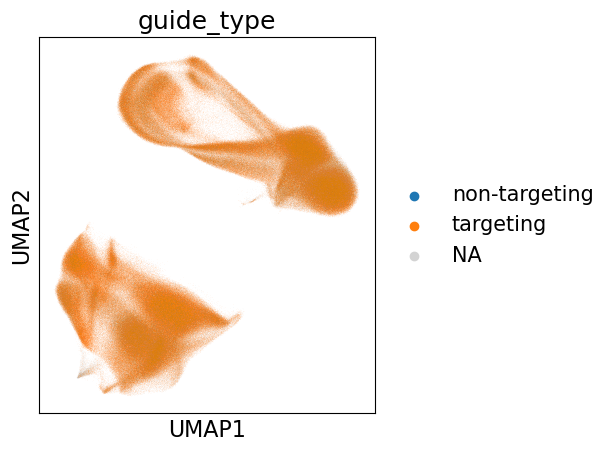

In [106]:
sc.pl.umap(adata, color='guide_type')

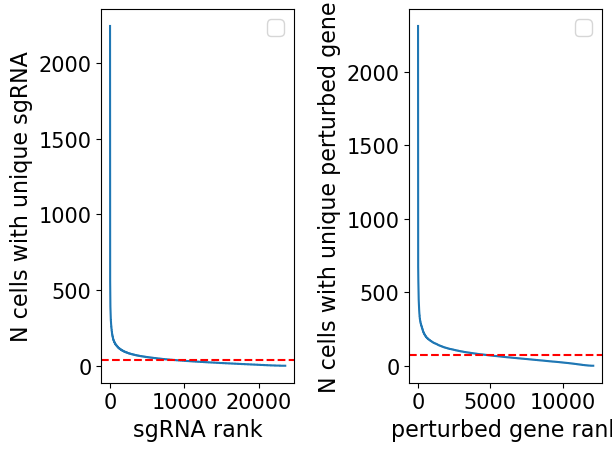

In [11]:
guide_cell_counts = adata.obs['guide_id'].value_counts()
guide_cell_counts.index = guide_cell_counts.index.astype(str)
plt.subplot(1,2,1);
plt.plot(guide_cell_counts[1:].values);
plt.axhline(y=guide_cell_counts[1:].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('sgRNA rank');
plt.ylabel('N cells with unique sgRNA');
plt.legend([])


gene_cell_counts = adata.obs['perturbed_gene_name'].value_counts()
gene_cell_counts.index = gene_cell_counts.index.astype(str)

plt.subplot(1,2,2);
plt.plot(gene_cell_counts[1:].values);
plt.axhline(y=gene_cell_counts[1:].mean(), color='r', linestyle='--', label='Mean')
plt.xlabel('perturbed gene rank');
plt.ylabel('N cells with unique perturbed gene');
plt.legend([])

In [14]:
adata = adata[adata.obs['QC_mask']].copy()

In [22]:
count_perturbed_genes = adata.obs['perturbed_gene_name'].value_counts()[1:]
test_perturbed_genes = count_perturbed_genes[count_perturbed_genes >= 3].index
# Split the perturbed genes into groups of 100
test_perturbed_genes_list = [test_perturbed_genes[i:i+100] for i in range(0, len(test_perturbed_genes), 100)]

In [40]:
all_kd_results_c = pd.DataFrame()
for t_genes in test_perturbed_genes_list:
    t_genes = t_genes.to_list()
    perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(adata[adata.obs['perturbed_gene_name'].isin(t_genes + ['NTC'])])
    kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)
    all_kd_results_c = pd.concat([all_kd_results_c, kd_results_c])

In [42]:
all_kd_results_c.to_csv(f'{datadir}/knockdown_efficacy_simple.csv')

In [69]:
all_kd_results_c = pd.read_csv(f'{datadir}/knockdown_efficacy_simple.csv', index_col=0)

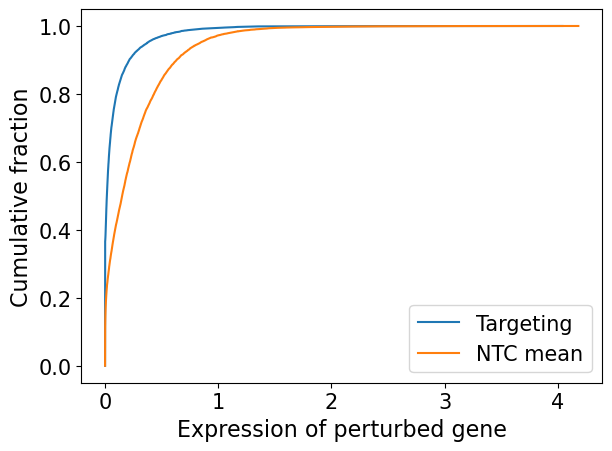

In [67]:
# Plot cumulative distributions
plt.plot(np.sort(all_kd_results_c['perturbed_gene_expr']),
         np.linspace(0, 1, len(all_kd_results_c['perturbed_gene_expr'])), label='Targeting')
plt.plot(np.sort(all_kd_results_c['perturbed_gene_mean_ntc']),
         np.linspace(0, 1, len(all_kd_results_c['perturbed_gene_mean_ntc'])), label='NTC mean')
plt.xlabel('Expression of perturbed gene');
plt.ylabel('Cumulative fraction');
plt.legend()

In [70]:
all_kd_results_c

perturbed_gene  perturbed_gene_expr  perturbed_gene_mean_ntc  \
0   ENSG00000012223             0.000000                 0.000000   
1   ENSG00000012822             0.003279                 0.095198   
2   ENSG00000026025             2.006651                 2.594920   
3   ENSG00000033867             0.032208                 0.551298   
4   ENSG00000034693             0.032066                 0.147726   
..              ...                  ...                      ...   
64  ENSG00000214078             0.000000                 0.828890   
65  ENSG00000244038             0.000000                 0.538475   
66  ENSG00000248098             0.000000                 0.176055   
67  ENSG00000269335             0.995973                 0.411272   
68  ENSG00000288701             0.385224                 0.271795   

    perturbed_gene_std_ntc  n_ntc_cells  perturbed_gene_expr_std  \
0                 0.000000      39459.0                 0.000000   
1                 0.286363      39459.0                 0.042971   
2                 1.064016      39459.0                 1.201968   
3                 0.551828      39459.0                 0.159126   
4                 0.308244      39459.0                 0.147905   
..                     ...          ...                      ...   
64                0.593935      39459.0                 0.000000   
65                0.511054      39459.0                 0.000000   
66                0.345522      39459.0                 0.000000   
67                0.480226      39459.0                 0.985211   
68                0.424600      39459.0                 0.667227   

    n_perturbed_cells  t_statistic        p_value    adj_p_value  \
0                 449          NaN            NaN            NaN   
1                 516   -38.648063  3.005459e-217  1.397538e-216   
2                 914   -14.663909   5.031469e-44   7.311354e-44   
3                 377   -59.986581  1.167694e-221  5.715556e-221   
4                 360   -14.551766   1.373093e-38   1.934812e-38   
..                ...          ...            ...            ...   
64                  3  -277.223919   0.000000e+00   0.000000e+00   
65                  3  -209.301359   0.000000e+00   0.000000e+00   
66                  3  -101.215152   0.000000e+00   0.000000e+00   
67                  3     1.027923   4.120478e-01   5.467558e-01   
68                  3     0.294445   7.961658e-01   8.583662e-01   

    signif_knockdown  
0              False  
1               True  
2               True  
3               True  
4               True  
..               ...  
64              True  
65              True  
66              True  
67             False  
68             False  

[11236 rows x 11 columns]

In [71]:
order_genes

array(['ENSG00000166710', 'ENSG00000205542', 'ENSG00000075624', ...,
       'ENSG00000123307', 'ENSG00000120594', 'ENSG00000012223'],
      dtype=object)

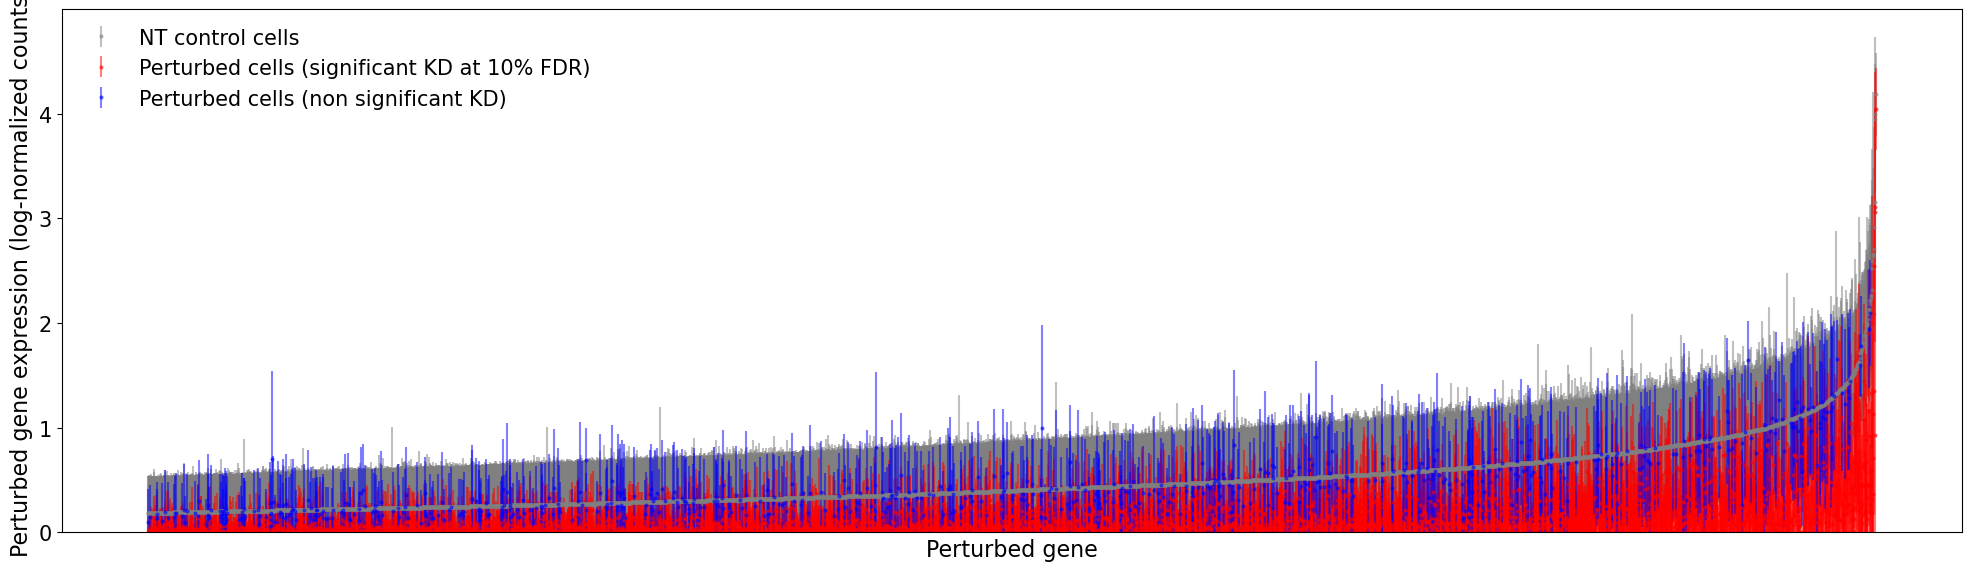

In [89]:
mean_perturbed_gene_expr_df = all_kd_results_c.copy()
# Find duplicate values in perturbed_gene
duplicates = mean_perturbed_gene_expr_df['perturbed_gene'].duplicated(keep=False)
mean_perturbed_gene_expr_df = mean_perturbed_gene_expr_df[~duplicates].copy()

mean_perturbed_gene_expr_df['rank'] = mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank()
mean_perturbed_gene_expr_df = mean_perturbed_gene_expr_df.sort_values('rank')
mean_perturbed_gene_expr_df['perturbed_gene'] = pd.Categorical(
    mean_perturbed_gene_expr_df['perturbed_gene'],
    categories=mean_perturbed_gene_expr_df['perturbed_gene'].tolist(),
    ordered=True
)

# mean_perturbed_gene_expr_df['perturbed_gene'] = pd.Categorical(
#     mean_perturbed_gene_expr_df['perturbed_gene'], 
#     categories=order_genes, 
#     ordered=True
# )

pl_df = mean_perturbed_gene_expr_df[mean_perturbed_gene_expr_df['perturbed_gene'].isin(order_genes[0:5000])].sort_values('perturbed_gene')
plt.figure(figsize=(20,6))
# Plot mean NTC expression with error bars
plt.errorbar(pl_df['perturbed_gene'],
             pl_df['perturbed_gene_mean_ntc'], 
             yerr=pl_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=2,
             alpha=0.5,
             label='NT control cells')

# Add stripplot of perturbed expression
plt.errorbar(pl_df[pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='red',
           alpha=0.5,
           label='Perturbed cells (significant KD at 10% FDR)')
plt.errorbar(pl_df[~pl_df.signif_knockdown]['perturbed_gene'],
           pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr'],
           yerr=pl_df[~pl_df.signif_knockdown]['perturbed_gene_expr_std'],
           fmt='o',
           markersize=2,
           color='blue',
           alpha=0.5,
           label='Perturbed cells (non significant KD)')

plt.xticks([])
plt.ylim(0)
plt.xlabel('Perturbed gene')
plt.ylabel('Perturbed gene expression (log-normalized counts)')
plt.legend(frameon=False);
plt.tight_layout()

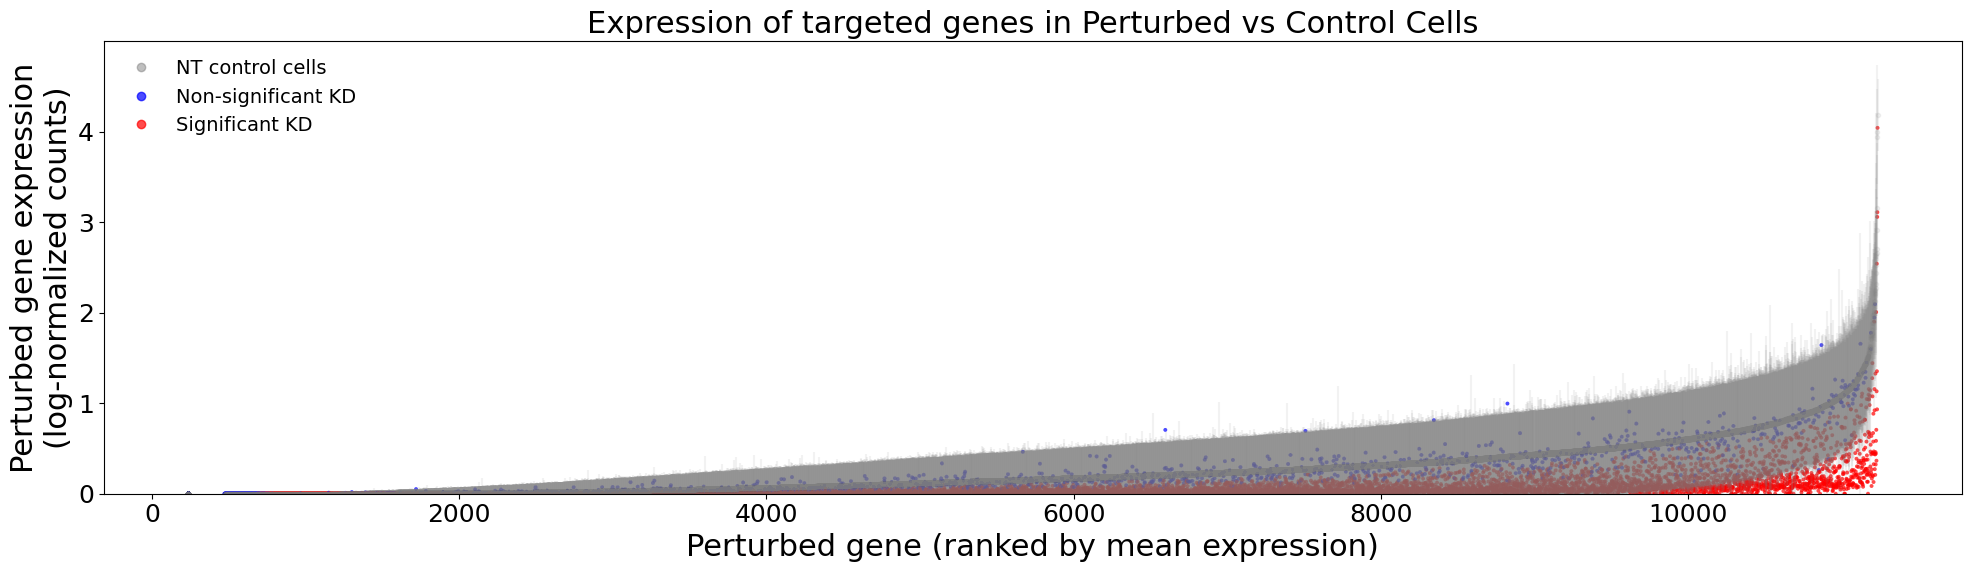

In [85]:
plt.figure(figsize=(20,6))
mean_perturbed_gene_expr_df['rank'] = mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank()
# # Plot mean NTC expression with error bars
plt.errorbar(mean_perturbed_gene_expr_df['rank'],
             mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'], 
             yerr=mean_perturbed_gene_expr_df['perturbed_gene_std_ntc'],
             fmt='o',
             color='grey',
             markersize=3, 
             alpha=0.1,
             label='NT control cells')

# Color points based on significance
sns.scatterplot(
    data=mean_perturbed_gene_expr_df, 
    y='perturbed_gene_expr', 
    x=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'].rank(), 
    s=8, 
    hue='signif_knockdown',
    palette={True: 'red', False: 'blue'},
    hue_order=[True, False],
    legend=False,
    alpha=0.7,
    linewidth=0)

# Add legend for both errorbar and scatterplot
plt.legend([plt.Line2D([0], [0], marker='o', color='grey', linestyle='', alpha=0.5),
            plt.Line2D([0], [0], marker='o', color='blue', linestyle='', alpha=0.7),
            plt.Line2D([0], [0], marker='o', color='red', linestyle='', alpha=0.7)],
           ['NT control cells', 'Non-significant KD', 'Significant KD'],
           loc='upper left', frameon=False, fontsize=14)
plt.ylim(0)
plt.xlabel('Perturbed gene (ranked by mean expression)', fontsize=22)
plt.ylabel('Perturbed gene expression\n(log-normalized counts)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Expression of targeted genes in Perturbed vs Control Cells', fontsize=22)

save_plot('ontarget_knockdown.png')



<Axes: xlabel='perturbed_gene_mean_ntc', ylabel='perturbed_gene_expr'>

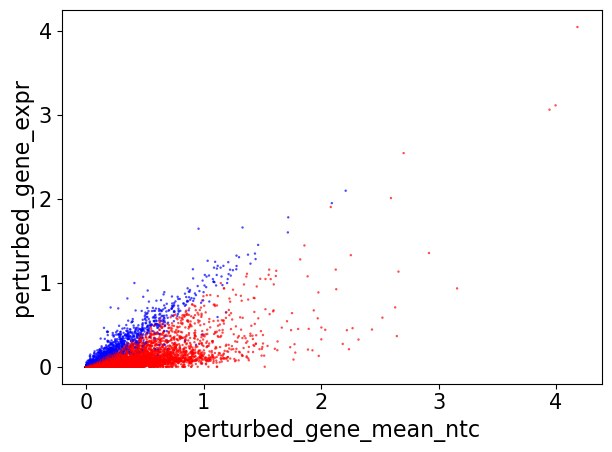

In [88]:
# Color points based on significance
sns.scatterplot(
    data=mean_perturbed_gene_expr_df, 
    y='perturbed_gene_expr', 
    x=mean_perturbed_gene_expr_df['perturbed_gene_mean_ntc'], 
    s=3, 
    hue='signif_knockdown',
    palette={True: 'red', False: 'blue'},
    hue_order=[True, False],
    legend=False,
    alpha=0.7,
    linewidth=0)


In [59]:
all_conditions = adata.obs['culture_condition'].unique()
all_donors = adata.obs['donor_id'].unique()
all_conditions_tests = {}
for c in all_conditions:
    for d in all_donors:
        print(d, ' - ', c)
        ad_c = adata[(adata.obs['culture_condition'] == c) & (adata.obs['donor_id'] == d)].copy()
        perturbed_gene_expr_df = qc_plots.calculate_perturbed_gene_expression(ad_c)
        kd_results_c = qc_plots.test_knockdown_simple(perturbed_gene_expr_df)
        kd_results_c['culture_condition'] = c
        all_conditions_tests[d + '-' + c] = kd_results_c

CE0008162  -  Rest
CE0010866  -  Rest
CE0008162  -  Stim8hr
CE0010866  -  Stim8hr


In [60]:
for k in all_conditions_tests.keys():
    print(all_conditions_tests[k].signif_knockdown.value_counts())

signif_knockdown
True     6520
False    4544
Name: count, dtype: int64
signif_knockdown
True     6255
False    4444
Name: count, dtype: int64
signif_knockdown
True     6380
False    4612
Name: count, dtype: int64
signif_knockdown
True     6436
False    4394
Name: count, dtype: int64


In [61]:
all_conditions_tests['CE0008162-Rest']

perturbed_gene  perturbed_gene_expr  perturbed_gene_mean_ntc  \
0                AKAP2                  NaN                      NaN   
1      ENSG00000000003             0.000000                 0.000000   
2      ENSG00000000419             0.471583                 0.588489   
3      ENSG00000000457             0.000000                 0.192355   
4      ENSG00000000460             0.000000                 0.265089   
...                ...                  ...                      ...   
11059             OCLM                  NaN                      NaN   
11060            SEPT6                  NaN                      NaN   
11061           SGK494                  NaN                      NaN   
11062          SMIM11B                  NaN                      NaN   
11063          U2AF1L5                  NaN                      NaN   

       perturbed_gene_std_ntc  n_ntc_cells  perturbed_gene_expr_std  \
0                         NaN       3580.0                      NaN   
1                    0.000000       3580.0                 0.000000   
2                    0.562836       3580.0                 0.527792   
3                    0.382127       3580.0                 0.000000   
4                    0.457865       3580.0                 0.000000   
...                       ...          ...                      ...   
11059                     NaN       3580.0                      NaN   
11060                     NaN       3580.0                      NaN   
11061                     NaN       3580.0                      NaN   
11062                     NaN       3580.0                      NaN   
11063                     NaN       3580.0                      NaN   

       n_perturbed_cells  t_statistic        p_value    adj_p_value  \
0                      0          NaN            NaN            NaN   
1                     10          NaN            NaN            NaN   
2                     10    -0.699337   5.019049e-01   5.591985e-01   
3                      2   -30.118686  7.991381e-178  4.157358e-177   
4                      2   -34.641426  5.047364e-227  3.424313e-226   
...                  ...          ...            ...            ...   
11059                  0          NaN            NaN            NaN   
11060                  0          NaN            NaN            NaN   
11061                  0          NaN            NaN            NaN   
11062                  0          NaN            NaN            NaN   
11063                  0          NaN            NaN            NaN   

       signif_knockdown culture_condition  
0                 False              Rest  
1                 False              Rest  
2                 False              Rest  
3                  True              Rest  
4                  True              Rest  
...                 ...               ...  
11059             False              Rest  
11060             False              Rest  
11061             False              Rest  
11062             False              Rest  
11063             False              Rest  

[11064 rows x 12 columns]

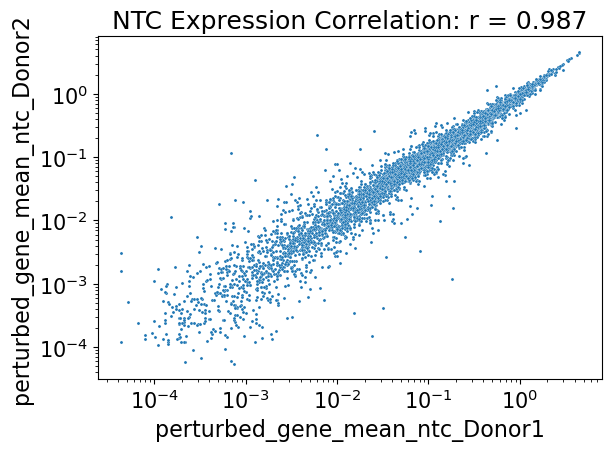

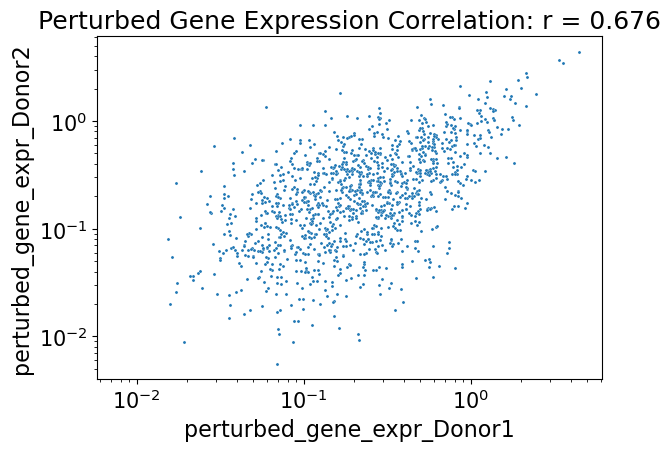

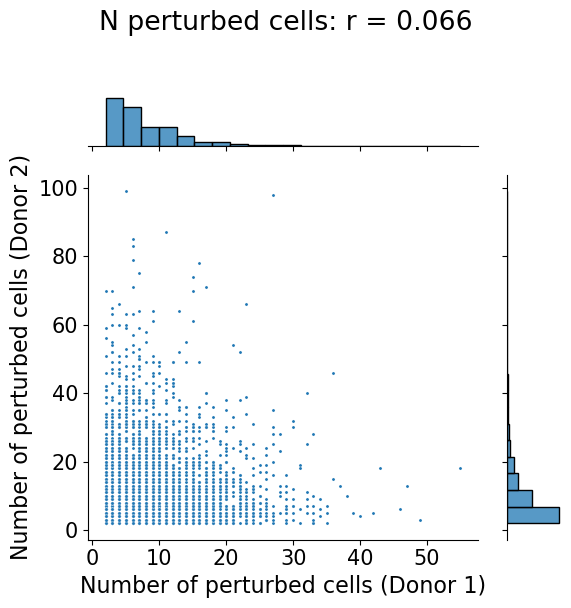

In [62]:
stats_cols = ['perturbed_gene', 't_statistic', 'perturbed_gene_expr', 'perturbed_gene_mean_ntc', 'adj_p_value', 'signif_knockdown', 'n_perturbed_cells']
merged_stats = pd.merge(
    all_conditions_tests['CE0008162-Rest'][stats_cols],
    all_conditions_tests['CE0010866-Rest'][stats_cols],
    on='perturbed_gene', 
    suffixes=('_Donor1', '_Donor2')
).dropna()

# Calculate correlation coefficients
corr_ntc = merged_stats['perturbed_gene_mean_ntc_Donor1'].corr(merged_stats['perturbed_gene_mean_ntc_Donor2'])
corr_expr = merged_stats['perturbed_gene_expr_Donor1'].corr(merged_stats['perturbed_gene_expr_Donor2'])

# Plot NTC expression with correlation
sns.scatterplot(data=merged_stats, x='perturbed_gene_mean_ntc_Donor1', y='perturbed_gene_mean_ntc_Donor2', s=5);
plt.xscale('log');plt.yscale('log');
plt.title(f'NTC Expression Correlation: r = {corr_ntc:.3f}');
plt.show()

# Plot perturbed gene expression with correlation
sns.scatterplot(data=merged_stats, x='perturbed_gene_expr_Donor1', y='perturbed_gene_expr_Donor2', s=5);
plt.xscale('log');plt.yscale('log');
plt.title(f'Perturbed Gene Expression Correlation: r = {corr_expr:.3f}');
plt.show()

col = 'n_perturbed_cells'
corr_ntc = merged_stats[f'{col}_Donor1'].corr(merged_stats[f'{col}_Donor2'])

# Plot number of perturbed cells with correlation and marginals
g = sns.jointplot(
    x=merged_stats[f'{col}_Donor1'], 
    y=merged_stats[f'{col}_Donor2'], 
    s=5,
    marginal_kws=dict(bins=20, fill=True),
    height=6
)
g.set_axis_labels('Number of perturbed cells (Donor 1)', 'Number of perturbed cells (Donor 2)')
g.fig.suptitle(f'N perturbed cells: r = {corr_ntc:.3f}', y=1.02)
plt.tight_layout()
plt.show()

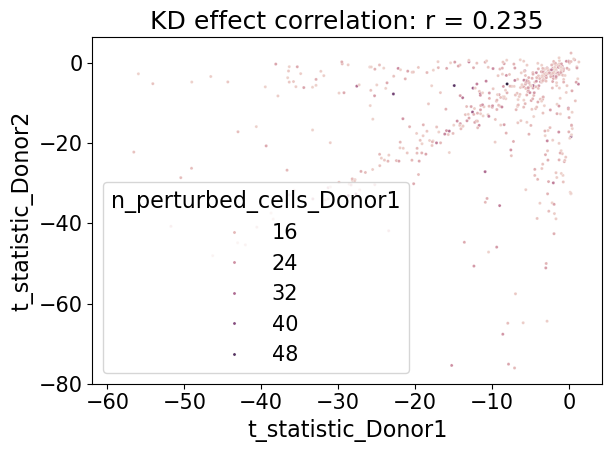

In [63]:
comparable_merged_stats = merged_stats[(merged_stats[['n_perturbed_cells_Donor1', 'n_perturbed_cells_Donor2']] > 10).sum(1) > 1]
# Calculate correlation coefficients
col = 't_statistic'
corr_ntc = comparable_merged_stats[f'{col}_Donor1'].corr(comparable_merged_stats[f'{col}_Donor2'])

# Plot NTC expression with correlation
sns.scatterplot(x=comparable_merged_stats[f'{col}_Donor1'], y=comparable_merged_stats[f'{col}_Donor2'], s=5, 
                hue=comparable_merged_stats['n_perturbed_cells_Donor1']);
# plt.xscale('log');plt.yscale('log');
plt.title(f'KD effect correlation: r = {corr_ntc:.3f}');
plt.show()


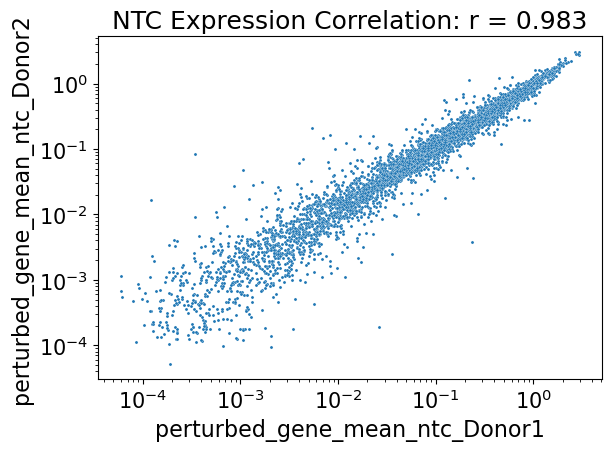

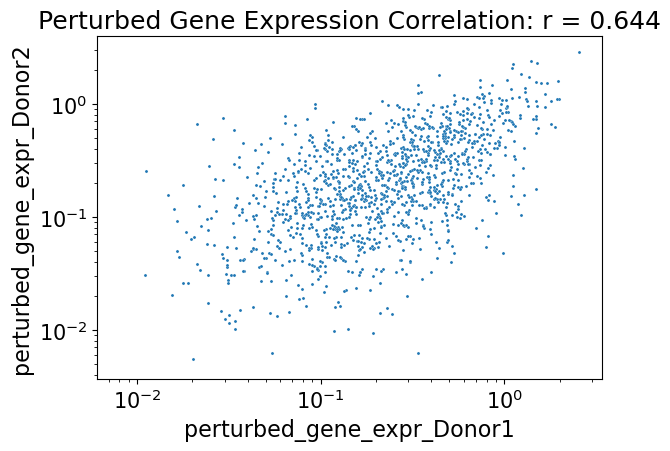

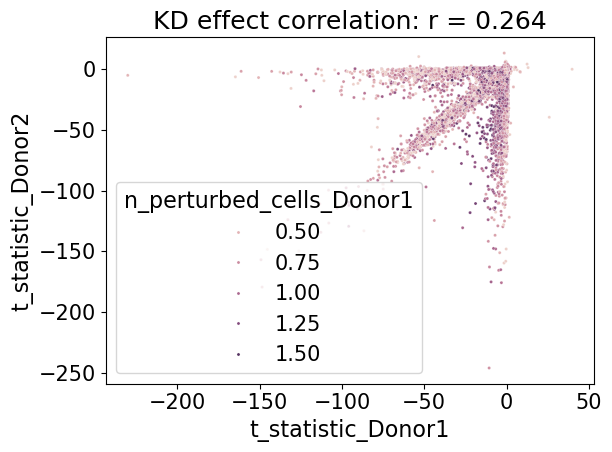

In [66]:
merged_stats = pd.merge(
    all_conditions_tests['CE0008162-Stim8hr'][stats_cols],
    all_conditions_tests['CE0010866-Stim8hr'][stats_cols],
    on='perturbed_gene', 
    suffixes=('_Donor1', '_Donor2')
).dropna()

# Calculate correlation coefficients
corr_ntc = merged_stats['perturbed_gene_mean_ntc_Donor1'].corr(merged_stats['perturbed_gene_mean_ntc_Donor2'])
corr_expr = merged_stats['perturbed_gene_expr_Donor1'].corr(merged_stats['perturbed_gene_expr_Donor2'])

# Plot NTC expression with correlation
sns.scatterplot(data=merged_stats, x='perturbed_gene_mean_ntc_Donor1', y='perturbed_gene_mean_ntc_Donor2', s=5);
plt.xscale('log');plt.yscale('log');
plt.title(f'NTC Expression Correlation: r = {corr_ntc:.3f}');
plt.show()

# Plot perturbed gene expression with correlation
sns.scatterplot(data=merged_stats, x='perturbed_gene_expr_Donor1', y='perturbed_gene_expr_Donor2', s=5);
plt.xscale('log');plt.yscale('log');
plt.title(f'Perturbed Gene Expression Correlation: r = {corr_expr:.3f}');
plt.show()

# Calculate correlation coefficients
col = 't_statistic'
corr_ntc = merged_stats[f'{col}_Donor1'].corr(merged_stats[f'{col}_Donor2'])

# Plot NTC expression with correlation
sns.scatterplot(x=merged_stats[f'{col}_Donor1'], y=merged_stats[f'{col}_Donor2'], s=5,  hue=np.log10(merged_stats['n_perturbed_cells_Donor1']));
# plt.xscale('log');plt.yscale('log');
plt.title(f'KD effect correlation: r = {corr_ntc:.3f}');
plt.show()


In [85]:
merged_stats[['signif_knockdown_Donor1', 'signif_knockdown_Donor2']].value_counts()

signif_knockdown_Donor1  signif_knockdown_Donor2
True                     True                       4582
False                    True                        948
True                     False                       779
False                    False                       663
Name: count, dtype: int64

In [ ]:
all_conditions_tests

### Compare expression profiles of cells with the same perturbation across donors

In [208]:
adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.counts.postQC.h5ad')

In [209]:
adata = adata[~adata.obs['guide_id'].isna()].copy()
adata.obs['perturbed_gene_name'] = np.where(adata.obs['guide_id'].str.startswith("NTC-"), 'NO-TARGET', adata.obs['perturbed_gene_name'])

In [210]:
aggr_adata = sc.get.aggregate(adata[(~adata.obs['guide_id'].isna()) & (adata.obs['guide_id']!='multi_sgRNA')], ['donor_id', 'guide_id', 'culture_condition'], func='sum')
aggr_adata

AnnData object with n_obs × n_vars = 71934 × 18129
    obs: 'donor_id', 'guide_id', 'culture_condition'
    var: 'gene_ids', 'gene_name', 'mt'
    layers: 'sum'

In [211]:
adata.X.data

array([2., 1., 1., ..., 2., 1., 1.], dtype=float32)

In [212]:
rest_aggr_adata = aggr_adata[aggr_adata.obs['culture_condition'] == 'Rest'].copy()
stim_aggr_adata = aggr_adata[aggr_adata.obs['culture_condition'] != 'Rest'].copy()

In [213]:
sc.pp.normalize_total(rest_aggr_adata, layer='sum')
sc.pp.log1p(rest_aggr_adata, layer='sum')
sc.pp.highly_variable_genes(rest_aggr_adata, layer='sum', subset=True, n_top_genes=10000)

sc.pp.normalize_total(stim_aggr_adata, layer='sum')
sc.pp.log1p(stim_aggr_adata, layer='sum')
sc.pp.highly_variable_genes(stim_aggr_adata, layer='sum', subset=True, n_top_genes=10000)

In [288]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics.pairwise import cosine_distances
import scipy.sparse

def calculate_perturbation_comparisons(adata, control_name="NTC"):
    """
    Calculate cosine distances between:
    1. The same perturbation across two donors
    2. Each perturbation and control guides
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object containing gene expression data
    control_name : str or list
        Name(s) of the control perturbation(s)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with guide1, guide2, cosine_distance, and comparison_type
    """
    # Ensure control_name is a list
    if isinstance(control_name, str):
        control_names = [control_name]
    else:
        control_names = control_name
    
    # Extract unique donors
    donors = adata.obs['donor_id'].unique()
    if len(donors) != 2:
        raise ValueError(f"Expected exactly 2 donors, found {len(donors)}")
    
    donor1, donor2 = donors
    
    # Extract expression profiles
    X = adata.layers['sum']
    
    # Create a dictionary to store profiles by donor and guide
    profiles = {}
    
    # Collect all profiles
    for idx, (donor, guide) in enumerate(zip(adata.obs['donor_id'], adata.obs['guide_id'])):
        key = (donor, guide)
        if key not in profiles:
            profiles[key] = X[idx]
    
    # Prepare results container
    results = []
    
    # Get all perturbations excluding controls
    all_guides = set(adata.obs['guide_id'].unique())
    perturbations = all_guides - set(control_names)
    
    # 1. Compare same perturbation between donors
    for perturb in perturbations:
        donor1_key = (donor1, perturb)
        donor2_key = (donor2, perturb)
        
        # Check if both donors have this perturbation
        if donor1_key in profiles and donor2_key in profiles:
            donor1_profile = profiles[donor1_key]
            donor2_profile = profiles[donor2_key]
            
            # Calculate distance between donors for the same perturbation
            dist = cosine_distances([donor1_profile], [donor2_profile])[0][0]
            
            results.append({
                'guide1': f"{perturb}_{donor1}",
                'guide2': f"{perturb}_{donor2}",
                'guide1_donor': donor1,
                'guide2_donor': donor2,
                'cosine_distance': dist,
                'comparison_type': 'perturb_vs_perturb'
            })
            
            # 2. Compare each perturbation with all control guides
            for control in control_names:
                # Control in donor2 vs perturbation in donor1
                control_key = (donor2, control)
                if control_key in profiles:
                    control_profile = profiles[control_key]
                    dist = cosine_distances([donor1_profile], [control_profile])[0][0]
                    
                    results.append({
                        'guide1': f"{perturb}_{donor1}",
                        'guide2': f"{control}_{donor2}",
                        'guide1_donor': donor1,
                        'guide2_donor': donor2,
                        'cosine_distance': dist,
                        'comparison_type': 'perturb_vs_ntc'
                    })
                
                # Control in donor1 vs perturbation in donor2
                control_key = (donor1, control)
                if control_key in profiles:
                    control_profile = profiles[control_key]
                    dist = cosine_distances([donor2_profile], [control_profile])[0][0]
                    
                    results.append({
                        'guide1': f"{perturb}_{donor2}",
                        'guide2': f"{control}_{donor1}",
                        'guide1_donor': donor2,
                        'guide2_donor': donor1,
                        'cosine_distance': dist,
                        'comparison_type': 'perturb_vs_ntc'
                    })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    return results_df

In [289]:
guides_double = rest_aggr_adata.obs[~rest_aggr_adata.obs.guide_id.str.startswith("NTC-")].value_counts('guide_id')
guides_double = guides_double[guides_double > 1].index.tolist()

ntc_guides_double = rest_aggr_adata.obs[rest_aggr_adata.obs.guide_id.str.startswith("NTC-")].value_counts('guide_id')
ntc_guides_double = ntc_guides_double[ntc_guides_double > 1].index.tolist()

In [309]:
test_perturbs = np.random.choice(guides_double, size=500).tolist() + ntc_guides_double[0:100]
ad = rest_aggr_adata[rest_aggr_adata.obs['guide_id'].isin(test_perturbs)].copy()
donor_comp = calculate_perturbation_comparisons(ad, control_name=ntc_guides_double[0:100])

In [321]:
donor_comp

guide1              guide2 guide1_donor guide2_donor  \
0      KLHL21-1_CE0008162  KLHL21-1_CE0010866    CE0008162    CE0010866   
1      KLHL21-1_CE0008162   NTC-750_CE0010866    CE0008162    CE0010866   
2      KLHL21-1_CE0010866   NTC-750_CE0008162    CE0010866    CE0008162   
3      KLHL21-1_CE0008162   NTC-468_CE0010866    CE0008162    CE0010866   
4      KLHL21-1_CE0010866   NTC-468_CE0008162    CE0010866    CE0008162   
...                   ...                 ...          ...          ...   
98887   ZDBF2-2_CE0010866   NTC-558_CE0008162    CE0010866    CE0008162   
98888   ZDBF2-2_CE0008162   NTC-556_CE0010866    CE0008162    CE0010866   
98889   ZDBF2-2_CE0010866   NTC-556_CE0008162    CE0010866    CE0008162   
98890   ZDBF2-2_CE0008162   NTC-555_CE0010866    CE0008162    CE0010866   
98891   ZDBF2-2_CE0010866   NTC-555_CE0008162    CE0010866    CE0008162   

       cosine_distance     comparison_type  
0             0.437293  perturb_vs_perturb  
1             0.417559      perturb_vs_ntc  
2             0.408956      perturb_vs_ntc  
3             0.285155      perturb_vs_ntc  
4             0.409546      perturb_vs_ntc  
...                ...                 ...  
98887         0.383473      perturb_vs_ntc  
98888         0.419625      perturb_vs_ntc  
98889         0.204538      perturb_vs_ntc  
98890         0.275996      perturb_vs_ntc  
98891         0.410612      perturb_vs_ntc  

[98892 rows x 6 columns]

Text(0, 0.5, 'density')

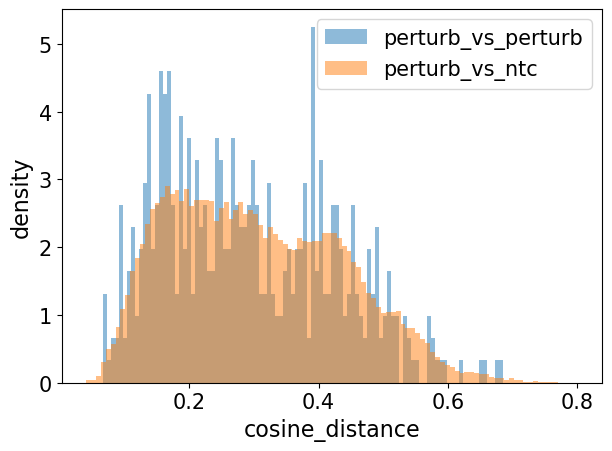

In [323]:
# Get data for each comparison type
perturb_vs_perturb = donor_comp[(donor_comp['comparison_type'] == 'perturb_vs_perturb') & (donor_comp['guide1_donor'] == 'CE0008162')]['cosine_distance']
perturb_vs_ntc = donor_comp[(donor_comp['comparison_type'] == 'perturb_vs_ntc') & (donor_comp['guide1_donor'] == 'CE0008162')]['cosine_distance']

# Plot histograms with normalized heights
plt.hist(perturb_vs_perturb, alpha=0.5, label='perturb_vs_perturb', density=True, bins=100)
plt.hist(perturb_vs_ntc, alpha=0.5, label='perturb_vs_ntc', density=True, bins=100)
plt.legend()
plt.xlabel('cosine_distance')
plt.ylabel('density')


<Axes: xlabel='comparison_type', ylabel='cosine_distance'>

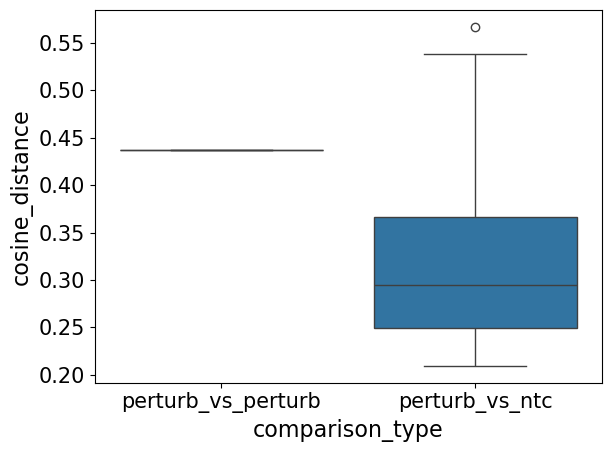

In [320]:
sns.boxplot(data=donor_comp[donor_comp['guide1'] == 'KLHL21-1_CE0008162'], x='comparison_type', y='cosine_distance')

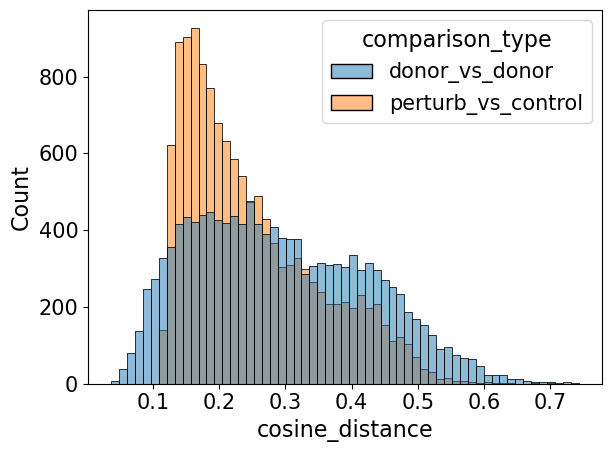

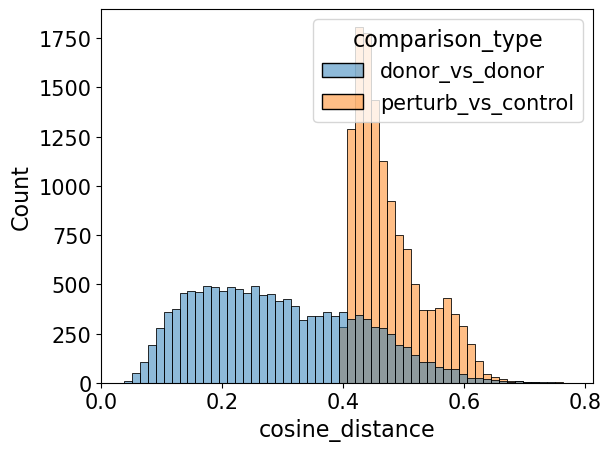

In [279]:
ntc_guide = np.random.choice(ntc_guides_double)

donor_comp = calculate_perturbation_comparisons(ad, control_name=ntc_guide)

sns.histplot(data=donor_comp[donor_comp['perturb_donor'] != 'CE0008162'], x='cosine_distance', hue='comparison_type');
plt.show()
sns.histplot(data=donor_comp[donor_comp['perturb_donor'] != 'CE0010866'], x='cosine_distance', hue='comparison_type');

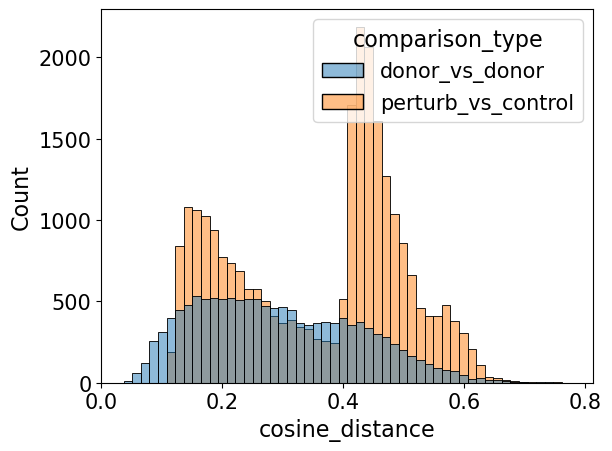

In [280]:
sns.histplot(data=donor_comp, x='cosine_distance', hue='comparison_type');

In [271]:
donor_comp = donor_comp.groupby(['perturbation', 'comparison_type'])['cosine_distance'].mean().reset_index().pivot(columns='comparison_type', index='perturbation', values='cosine_distance').sort_values('donor_vs_donor')

In [67]:
os.listdir(datadir)

['CRiCD4IL2_Illumina_merged.gex.lognorm.postQC.h5ad',
 'CRiCD4IL2D2_Stim8hr_10Xlane1_Illumina.sgRNA.h5ad',
 'CRiCD4IL2_Illumina_merged.gex.lognorm.h5ad',
 'knockdown_efficacy_simple.csv',
 'sgrna_assignment.csv',
 'CRiCD4IL2D1_Stim8hr_10Xlane1_Illumina.sgRNA.h5ad',
 'tmp',
 'CRiCD4IL2D1_Rest_10Xlane1_Illumina.sgRNA.h5ad',
 'cellranger_outs',
 'CRiCD4IL2D2_Rest_10Xlane1_Illumina.sgRNA.h5ad']

In [68]:
s_ad = sc.read_h5ad(datadir + 'CRiCD4IL2D1_Rest_10Xlane1_Illumina.sgRNA.h5ad')
s_ad

AnnData object with n_obs × n_vars = 132898 × 27272
    obs: 'library_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'sgrna_id', 'perturbed_gene_name', 'perturbation_type', 'sgrna_type', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mean_counts', 'total_counts', 'nonz_means', 'n_cells_outlier', 'inefficient', 'nonspecific'

In [96]:
s_ad = sc.read_10x_h5('/mnt/oak/users/emma/data/GWT/CRiCD4IL2/lane13_10x/CRiCD4IL2D2_Rest_sample_filtered_feature_bc_matrix.h5')
s_ad.var['gene_ids'].str.startswith('ENS').all()

True

In [103]:
[x for x in s_ad.var_names if 'Puro' in x or 'PURO' in x or 'CUSTOM' in x or 'PuroR' in x]

[]

## Count all sgRNA cells across lanes

In [4]:
obs_lane5 = sc.read_h5ad(f'/mnt/oak/users/emma/data/GWT/CRiCD4IL2_Illumina_lane5/CRiCD4IL2_Illumina_lane5_merged.gex.lognorm.postQC.h5ad', backed=True).obs.copy()
obs_lane13 = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC.h5ad', backed=True).obs.copy()
obs_lane21 = sc.read_h5ad(f'/mnt/oak/users/emma/data/GWT/CRiCD4IL2_Illumina/CRiCD4IL2_Illumina_merged.gex.lognorm.postQC.h5ad', backed=True).obs.copy()

In [5]:
obs_lane5.index = obs_lane5.index + '_lane5'
obs_lane21.index = obs_lane21.index + '_lane21'
obs_lane13.index = obs_lane13.index + '_lane13'
all_obs = pd.concat([obs_lane5, obs_lane13, obs_lane21])

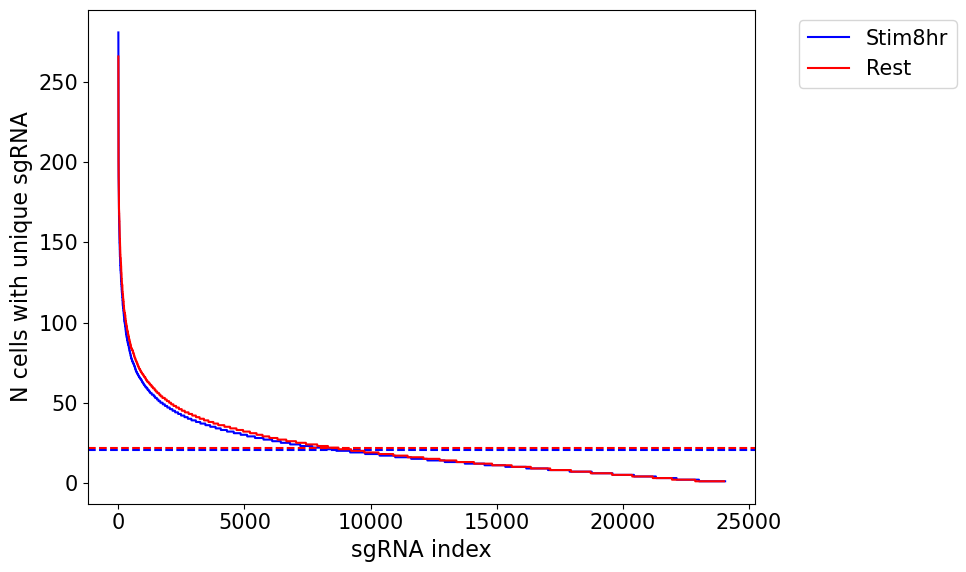

In [21]:
guide_cell_counts = all_obs[['perturbed_gene_name', 'guide_id', 'culture_condition']].value_counts().reset_index()
guide_cell_counts.columns = ['perturbed_gene_name', 'guide_id', 'culture_condition', 'count']

palette = {'Rest':'red', 'Stim8hr':'blue'}
# Plot cumulative distribution of counts per guide for each library_id
plt.figure(figsize=(10, 6))
for lib_id in guide_cell_counts['culture_condition'].unique():
    lib_counts = guide_cell_counts[guide_cell_counts['culture_condition'] == lib_id].sort_values('count', ascending=False)
    mean_count = lib_counts['count'].mean()
    plt.plot(np.arange(len(lib_counts)), lib_counts['count'], label=lib_id, color=palette[lib_id])
    plt.axhline(y=mean_count,linestyle='--', color=palette[lib_id])
plt.xlabel('sgRNA index');
plt.ylabel('N cells with unique sgRNA');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

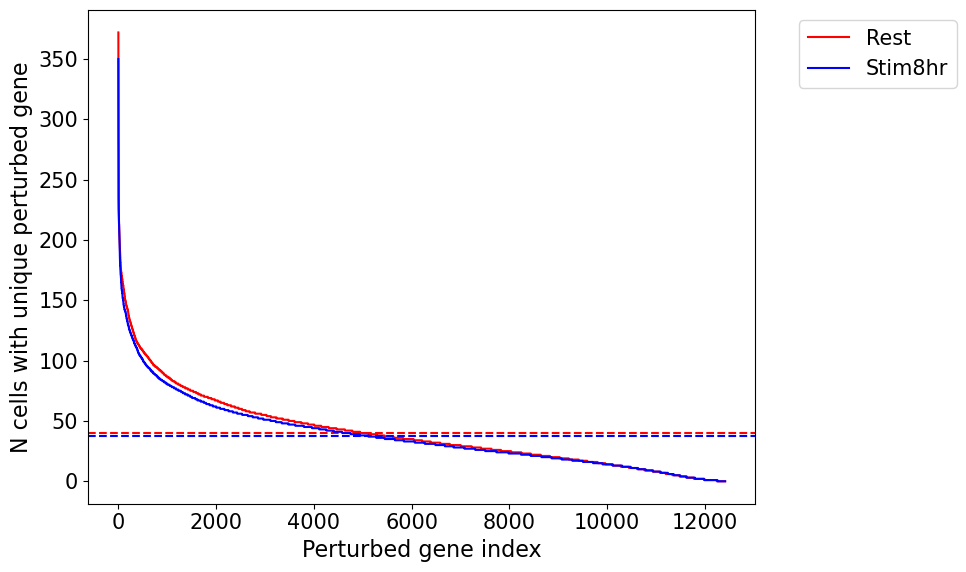

In [37]:
gene_cell_counts = guide_cell_counts.groupby(['perturbed_gene_name', 'culture_condition'])['count'].sum().reset_index()
gene_cell_counts.index = gene_cell_counts.index.astype(str)
gene_cell_counts = gene_cell_counts[gene_cell_counts['perturbed_gene_name'] != 'NTC']

plt.figure(figsize=(10, 6))
for lib_id in gene_cell_counts['culture_condition'].unique():
    lib_counts = gene_cell_counts[gene_cell_counts['culture_condition'] == lib_id].sort_values('count', ascending=False)
    mean_count = lib_counts['count'].mean()
    plt.plot(np.arange(len(lib_counts)), lib_counts['count'], label=lib_id, color=palette[lib_id])
    plt.axhline(y=mean_count,linestyle='--', color=palette[lib_id])
plt.xlabel('Perturbed gene index');
plt.ylabel('N cells with unique perturbed gene');
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# .groupby(['perturbed_gene_name', 'guide_id', 'library_id']).count()

In [91]:
guide_cell_counts = all_obs[['perturbed_gene_name', 'guide_id', 'library_id', 'culture_condition']].value_counts().reset_index()
guide_cell_counts['pass_filter'] = guide_cell_counts['count'] >= 3

passing_genes_rest = guide_cell_counts[guide_cell_counts['culture_condition'] == 'Rest'].groupby('perturbed_gene_name')['pass_filter'].sum().sort_values()
passing_genes_rest = passing_genes_rest.drop('NTC')

passing_genes_stim = guide_cell_counts[guide_cell_counts['culture_condition'] == 'Stim8hr'].groupby('perturbed_gene_name')['pass_filter'].sum().sort_values()
passing_genes_stim = passing_genes_stim.drop('NTC')

Text(0.5, 0, 'No. replicates with >= 5 cells')

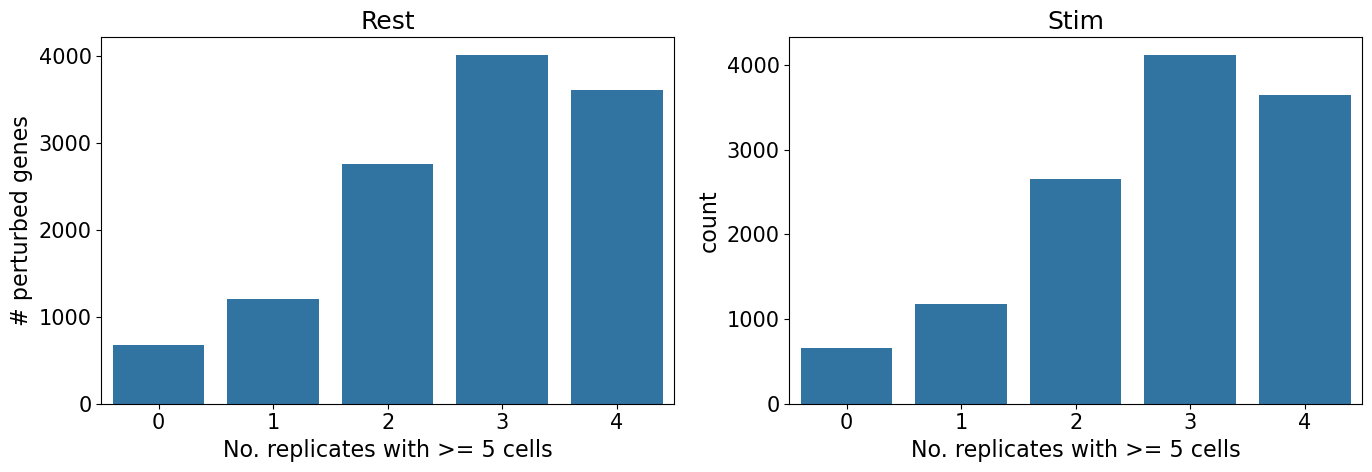

In [92]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1);
sns.barplot(passing_genes_rest.value_counts());
plt.title("Rest")
plt.xlabel("No. replicates with >= 5 cells")
plt.ylabel('# perturbed genes')
plt.subplot(1,2,2);
plt.title("Stim")
sns.barplot(passing_genes_stim.value_counts());
plt.xlabel("No. replicates with >= 5 cells")

In [93]:
print(passing_genes_rest[passing_genes_rest >= 3].shape)
print(passing_genes_stim[passing_genes_stim >= 3].shape)

(7612,)
(7769,)


In [95]:
np.intersect1d(
    passing_genes_rest[passing_genes_rest >= 3].index,
    passing_genes_stim[passing_genes_stim >= 3].index
    ).shape

(6720,)